# Constraining subglacial processes from surface velocity observations using surrogate-based Bayesian inference
## Part 1 - Training an ensemble of neural networks

In this notebook, we will illustrate the process of using Bayesian Bootstrap Aggregation (BayesBag) to train an ensemble of neural networks.  In this case, each ensemble member is one possible surrogate for the coupled hydrology-ice dynamics model described in the paper, mapping from a vector of 8 parameters to a velocity field.  We begin by importing both the parameters and the associated velocity fields computed by the physics model, which will act as training data for the surrogate.

In [34]:
import pickle
import numpy as np
import re
#import utilities
import xarray as xr
from collections import OrderedDict

thin = 5

o_file = "../data/observed_speeds/greenland_vel_mosaic250_v1_g1800m.nc"
o_xr = xr.open_dataset(o_file)

o_speed = o_xr.variables["velsurf_mag"].values[::thin,::thin]
o_speed_sigma = o_xr.variables["velsurf_mag_error"].values[::thin,::thin]

o_ny, o_nx = o_speed.shape
o_xr.close()

o_speeds = np.nan_to_num(o_speed, 0).reshape(-1, 1)
o_log_speeds = np.log10(o_speeds)
o_log_speeds[np.isneginf(o_log_speeds)] = 0

o_speeds_sigma = np.nan_to_num(o_speed_sigma, 0).reshape(-1, 1)

from glob import glob
s_files = glob("../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_*.nc")
s_files = list(OrderedDict.fromkeys(s_files))

nt = len(s_files)

# open first file to get the dimensions
vxr0 = xr.open_dataset(s_files[0])
speed = vxr0.variables["velsurf_mag"].values[:,::thin,::thin]
_, ny, nx = speed.shape
vxr0.close()

m_speeds = np.zeros((nt, ny * nx))

# Go through all files and don't forget to extract the experiment id
ids = []
for k, s_file in enumerate(s_files):
    print(f"Reading {s_file}")
    vxr = xr.open_dataset(s_file)
    ids.append(re.search("id_(.+?)_0", s_file).group(1))
    m_speeds[k, ::] = vxr.variables["velsurf_mag"].values[:,::thin,::thin].flatten()
    vxr.close()

# For comparison, we run the analysis for both u and log10(u)
m_speeds_mean = np.nanmean(m_speeds, axis=0)
m_speeds_anom = m_speeds - m_speeds_mean
m_speeds_anom = np.nan_to_num(m_speeds_anom, 0)

m_log_speeds = np.log10(np.nan_to_num(m_speeds, 0))
m_log_speeds[np.isneginf(m_log_speeds)] = 0
m_log_speeds_mean = np.nanmean(m_log_speeds, axis=0)
m_log_speeds_anom =  m_log_speeds - m_log_speeds_mean
m_log_speeds_anom[np.isneginf(m_log_speeds_anom)] = 0
m_log_speeds_anom = np.nan_to_num(m_log_speeds_anom, 0)

/var/folders/sn/_0x14wz901q964z4l3012ckh0000gn/T/ipykernel_89841/1493355826.py:20: RuntimeWarning: divide by zero encountered in log10
  o_log_speeds = np.log10(o_speeds)


Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_10_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_110_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_111_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_113_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_114_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_11_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_13_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_14_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_16_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_17_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_19_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_1_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_21_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_22_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_23_

Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_128_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_129_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_130_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_131_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_132_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_133_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_134_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_135_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_136_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_138_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_139_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_140_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_141_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_142_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800

Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_252_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_253_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_254_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_255_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_256_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_257_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_258_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_259_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_260_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_261_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_262_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_263_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_264_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_265_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800

Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_378_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_379_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_380_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_381_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_382_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_383_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_384_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_385_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_386_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_387_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_388_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_389_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_390_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_391_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800

Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_499_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_500_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_501_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_502_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_503_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_504_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_506_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_510_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_511_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_512_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_513_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_514_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_505_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_507_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800

Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_632_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_633_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_634_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_635_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_636_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_637_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_638_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_640_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_641_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_642_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_645_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_646_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_647_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_648_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800

Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_757_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_758_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_759_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_760_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_761_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_762_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_763_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_764_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_765_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_766_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_767_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_768_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_769_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_770_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800

Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_886_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_887_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_888_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_889_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_890_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_891_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_892_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_893_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_894_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_895_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_896_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_879_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_897_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_898_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800

Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_990_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_991_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_992_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_993_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_994_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_995_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_996_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_997_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_998_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_999_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_20_0_50.nc


/var/folders/sn/_0x14wz901q964z4l3012ckh0000gn/T/ipykernel_89841/1493355826.py:53: RuntimeWarning: divide by zero encountered in log10
  m_log_speeds = np.log10(np.nan_to_num(m_speeds, 0))


In [3]:
import pandas as pd
response_file = "log_speeds.csv"
df = pd.DataFrame(data=m_log_speeds, index=ids)
df.to_csv(response_file, index_label="id")

In [4]:
from pismemulator.utils import prepare_data
import pandas as pd
response_file = "log_speeds.csv"
samples_file = "../data/samples/velocity_calibration_samples_100.csv"
samples, response = prepare_data(samples_file, response_file)


Preparing sample ../data/samples/velocity_calibration_samples_100.csv and response log_speeds.csv
The following simulation ids are missing:
   [0, 337, 595, 539, 542]


The velocity fields have some bad simulations in them, so we filter out circumstances in which the model never ran past 12 years, and in which the max velocity was greater than 100km/a.

In [5]:
print(samples.shape)
print(response.shape)

F = response.values
X = samples.values

(995, 8)
(995, 53504)


In [6]:
response

,0,1,2,3,4,5,6,7,8,9,...,53494,53495,53496,53497,53498,53499,53500,53501,53502,53503
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We will use pytorch to construct and train the neural networks.  To this end, we will move the physical model's parameters and (log-)speed fields to pytorch, and use the GPU if it's available.

In [7]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

m = X.shape[0]

X = torch.from_numpy(X)
F = torch.from_numpy(F)
F[F<0] = 0

X = X.to(torch.float32)
F = F.to(torch.float32)

X = X.to(device)
F = F.to(device)

X_m = X.mean(axis=0)
X_s = X.std(axis=0)

#F_m = F.mean(axis=0)
#F_s = F.std(axis=0)

X = (X-X_m)/X_s
#F = (F-F_m)/(F_s + 1e-5)

#X_hat = torch.log10(X)

In [8]:
print(F.shape)

torch.Size([995, 53504])


Part of our objective function is to weight by element area.  We will grab those values from a .vtu of an observed velocity field.

In [9]:
import pickle
import numpy as np
#u_obs = utilities.VData('./data/u_observed.vtu')
#point_area = torch.tensor(u_obs.get_point_area(),dtype=torch.float,device=device)
normed_area = torch.tensor(np.ones(F.shape[1]),device=device)
normed_area/=normed_area.sum()
print(normed_area)

tensor([1.8690e-05, 1.8690e-05, 1.8690e-05,  ..., 1.8690e-05, 1.8690e-05,
        1.8690e-05], dtype=torch.float64)


Next we need to define a few functions and classes.  First, we will create a function that extracts eigenglaciers and constructs the matrix $\hat{V}$, corresponding to the Dimensionality Reduction section.

In [10]:
def get_eigenglaciers(omegas,F,cutoff=0.999):
    F_mean = (F*omegas).sum(axis=0)
    F_bar = F - F_mean # Eq. 28
    Z = torch.diag(torch.sqrt(omegas.squeeze()*m))
    U,S,V = torch.svd_lowrank(Z@F_bar,q=100)
    lamda = S**2/(m) 
    #print(S.shape)

    #lamda, V = torch.eig(S,eigenvectors=True) # Eq. 26
    #lamda = lamda[:,0].squeeze()
    
    cutoff_index = torch.sum(torch.cumsum(lamda/lamda.sum(),0)<cutoff)
    lamda_truncated = lamda.detach()[:cutoff_index]
    V = V.detach()[:,:cutoff_index]
    V_hat = V @ torch.diag(torch.sqrt(lamda_truncated)) # A slight departure from the paper: Vhat is the
                                                        # eigenvectors scaled by the eigenvalue size.  This
                                                        # has the effect of allowing the outputs of the neural
                                                        # network to be O(1).  Otherwise, it doesn't make 
                                                        # any difference.
    return V_hat, F_bar, F_mean

Second, we define the architecture of the neural network to be used as a surrogate.  This corresponds to the architecture defined in Fig. 3.

In [11]:
import torch.nn as nn

class Emulator(nn.Module):
    def __init__(self,n_parameters,n_eigenglaciers,n_hidden_1,n_hidden_2,n_hidden_3,n_hidden_4,V_hat,F_mean):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.l_1 = nn.Linear(n_parameters, n_hidden_1)
        self.norm_1 = nn.LayerNorm(n_hidden_1)
        self.dropout_1 = nn.Dropout(p=0.0)
        self.l_2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.norm_2 = nn.LayerNorm(n_hidden_2)
        self.dropout_2 = nn.Dropout(p=0.5)
        self.l_3 = nn.Linear(n_hidden_2, n_hidden_3)
        self.norm_3 = nn.LayerNorm(n_hidden_3)
        self.dropout_3 = nn.Dropout(p=0.5)
        self.l_4 = nn.Linear(n_hidden_3, n_hidden_4)
        self.norm_4 = nn.LayerNorm(n_hidden_3)
        self.dropout_4 = nn.Dropout(p=0.5)
        self.l_5 = nn.Linear(n_hidden_4, n_eigenglaciers)

        self.V_hat = torch.nn.Parameter(V_hat,requires_grad=False)
        self.F_mean = torch.nn.Parameter(F_mean,requires_grad=False)

    def forward(self, x, add_mean=False):
        # Pass the input tensor through each of our operations

        a_1 = self.l_1(x)
        a_1 = self.norm_1(a_1)
        a_1 = self.dropout_1(a_1)
        z_1 = torch.relu(a_1) 

        a_2 = self.l_2(z_1)
        a_2 = self.norm_2(a_2)
        a_2 = self.dropout_2(a_2)
        z_2 = torch.relu(a_2) + z_1

        a_3 = self.l_3(z_2)
        a_3 = self.norm_3(a_3)
        a_3 = self.dropout_3(a_3)
        z_3 = torch.relu(a_3) + z_2
        
        a_4 = self.l_4(z_3)
        a_4 = self.norm_3(a_4)
        a_4 = self.dropout_3(a_4)
        z_4 = torch.relu(a_4) + z_3
        
        z_5 = self.l_5(z_4)
        if add_mean:
            F_pred = z_5 @ self.V_hat.T + self.F_mean
        else:
            F_pred = z_5 @ self.V_hat.T

        return F_pred 

In [12]:
import torch.nn as nn

class EmulatorLearnableVhat(nn.Module):
    def __init__(self,n_parameters,n_eigenglaciers,n_hidden_1,n_hidden_2,n_hidden_3,n_hidden_4,n_grid_points,F_mean):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.l_1 = nn.Linear(n_parameters, n_hidden_1)
        self.norm_1 = nn.LayerNorm(n_hidden_1)
        self.dropout_1 = nn.Dropout(p=0.0)
        self.l_2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.norm_2 = nn.LayerNorm(n_hidden_2)
        self.dropout_2 = nn.Dropout(p=0.5)
        self.l_3 = nn.Linear(n_hidden_2, n_hidden_3)
        self.norm_3 = nn.LayerNorm(n_hidden_3)
        self.dropout_3 = nn.Dropout(p=0.5)
        self.l_4 = nn.Linear(n_hidden_3, n_hidden_4)
        self.norm_4 = nn.LayerNorm(n_hidden_3)
        self.dropout_4 = nn.Dropout(p=0.5)
        self.l_5 = nn.Linear(n_hidden_4, n_eigenglaciers)
        self.V_hat = nn.Linear(n_eigenglaciers,n_grid_points,bias=False)
        
        self.dropout_5 = nn.Dropout(p=0.3)

        #self.V_hat = torch.nn.Parameter(V_hat,requires_grad=False)
        self.F_mean = torch.nn.Parameter(F_mean,requires_grad=False)

    def forward(self, x, add_mean=False):
        # Pass the input tensor through each of our operations

        a_1 = self.l_1(x)
        a_1 = self.norm_1(a_1)
        a_1 = self.dropout_1(a_1)
        z_1 = torch.relu(a_1) 

        a_2 = self.l_2(z_1)
        a_2 = self.norm_2(a_2)
        a_2 = self.dropout_2(a_2)
        z_2 = torch.relu(a_2) + z_1

        a_3 = self.l_3(z_2)
        a_3 = self.norm_3(a_3)
        a_3 = self.dropout_3(a_3)
        z_3 = torch.relu(a_3) + z_2
        
        a_4 = self.l_4(z_3)
        a_4 = self.norm_3(a_4)
        a_4 = self.dropout_4(a_4)
        z_4 = torch.relu(a_4) + z_3
        
        z_5 = self.l_5(z_4)
        z_5 = self.dropout_5(z_5)
        z_6 = self.V_hat(z_5)
        if add_mean:
            F_pred = z_6 + self.F_mean
        else:
            F_pred = z_6
        return F_pred 

Third, we create an optimization procedure that trains a model for a given set of instance weights ($\omega_d$) and training data.  Optimization is performed using mini-batch gradient descent.

In [13]:
from torch.utils.data import TensorDataset

def criterion_ae(F_pred,F_obs,omegas,area):
    instance_misfit = torch.sum(torch.abs((F_pred - F_obs))**2*area,axis=1)
    return torch.sum(instance_misfit*omegas.squeeze())

def train_surrogate(e,X_train,F_train,omegas,area,batch_size=128,epochs=3000,eta_0=0.01,k=1000.):
    
    omegas_0 = torch.ones_like(omegas)/len(omegas)
    training_data = TensorDataset(X_train,F_train,omegas)

    batch_size = 128
    train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                               batch_size=batch_size, 
                                               shuffle=True)
    
    optimizer = torch.optim.Adam(e.parameters(),lr=eta_0,weight_decay=0.0)
    
    # Loop over the data
    for epoch in range(epochs):
        # Loop over each subset of data
        for param_group in optimizer.param_groups:
            param_group['lr'] = eta_0*(10**(-epoch/k))

        for x,f,o in train_loader:
            e.train()
            # Zero out the optimizer's gradient buffer
            optimizer.zero_grad()

            f_pred = e(x)

            # Compute the loss
            loss = criterion_ae(f_pred,f,o,area)

            # Use backpropagation to compute the derivative of the loss with respect to the parameters
            loss.backward()
        
            # Use the derivative information to update the parameters
            optimizer.step()
            
        e.eval()
        F_train_pred = e(X_train)
        # Make a prediction based on the model
        loss_train = criterion_ae(F_train_pred,F_train,omegas,area)
        # Make a prediction based on the model
        loss_test = criterion_ae(F_train_pred,F_train,omegas_0,area)

        # Print the epoch, the training loss, and the test set accuracy.
        if epoch%10==0:
            print(epoch,loss_train.item(),loss_test.item())

    

Here we put it all together: loop over the desired number of models, drawing random Bayesian bootstrap weights for each, training the surrogate, and saving the resulting models.  

In [14]:
from scipy.stats import dirichlet

torch.manual_seed(0)
np.random.seed(0)

n_parameters = X.shape[1]
n_hidden_1 = 128
n_hidden_2 = 128
n_hidden_3 = 128
n_hidden_4 = 128

In [16]:
n_models = 1 #To reproduce the paper, this should be 50
from scipy.stats import dirichlet
for model_index in range(n_models):
    omegas = torch.tensor(dirichlet.rvs(np.ones(m)),dtype=torch.float,device=device).T
   
    V_hat, F_bar, F_mean = get_eigenglaciers(omegas,F)
    n_eigenglaciers = V_hat.shape[1]
    n_grid_points = V_hat.shape[0]

    e = Emulator(n_parameters,n_eigenglaciers,n_hidden_1,n_hidden_2,n_hidden_3,n_hidden_4,V_hat,F_mean)
    e.to(device)
    
    train_surrogate(e,X,F_bar,omegas,normed_area,epochs=100)
    torch.save(e.state_dict(),'emulator_ensemble_doug/emulator_{0:03d}.h5'.format(model_index))


0 12.306413347955907 11.584780434367168
10 4.49525992954077 3.8974845373747975
20 3.948241204454658 3.7214626504311767
30 2.8643214619099493 3.423603270958989
40 1.2401592473170289 2.7768262760359184
50 2.3361090548127 3.117416950509862
60 1.0528928258882713 2.649517310834612
70 0.4330306823371761 1.7247466874184532
80 0.28805220694386974 1.6977763265907
90 0.2241709482452296 1.5062209566887024


22.220966
124.46567
157.98636


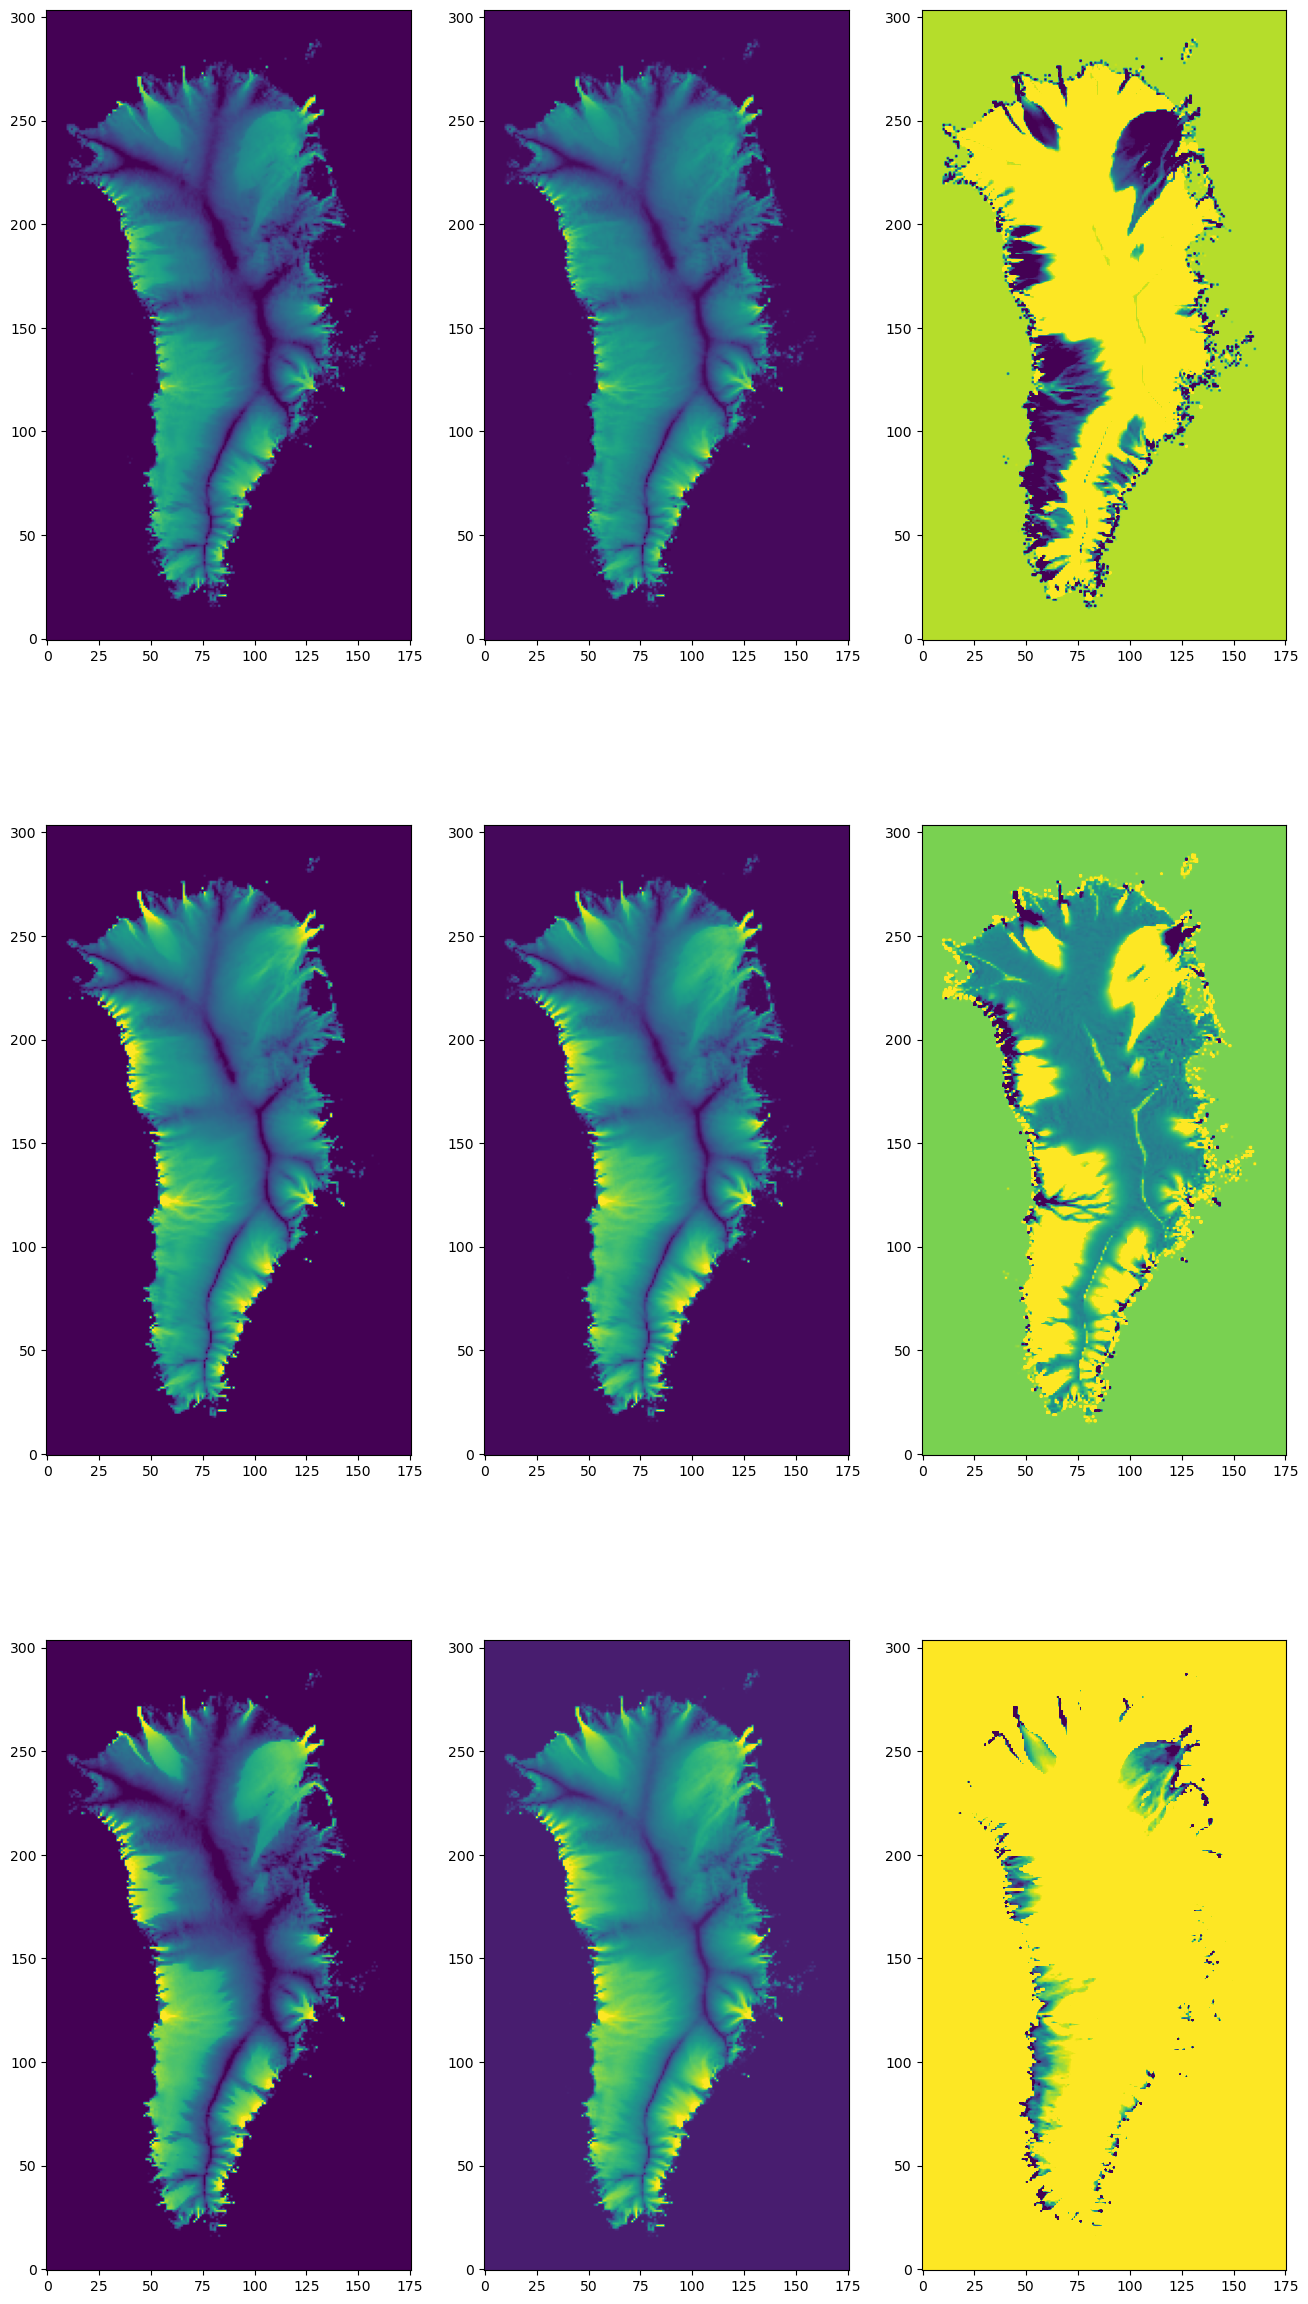

In [17]:
import matplotlib.pyplot as plt
F_pred = e(X,add_mean=True)
F_orig = F
fig,axs = plt.subplots(nrows=3,ncols=3)
fig.set_size_inches(16,30)
inds = np.random.randint(0,m,3)
axs[0,0].imshow(F_orig[inds[0],:].detach().cpu().numpy().reshape((ny,nx)),origin='lower',vmin=0,vmax=3)
axs[0,1].imshow(F_pred[inds[0],:].detach().cpu().numpy().reshape((ny,nx)),origin='lower',vmin=0,vmax=3)
axs[0,2].imshow((F_pred[inds[0],:].detach().cpu().numpy() - F_orig[inds[0],:].detach().cpu().numpy()).reshape((ny,nx)),origin='lower',vmin=-0.1,vmax=0.1)
axs[1,0].imshow(F_orig[inds[1],:].detach().cpu().numpy().reshape((ny,nx)),origin='lower',vmin=0,vmax=3)
axs[1,1].imshow(F_pred[inds[1],:].detach().cpu().numpy().reshape((ny,nx)),origin='lower',vmin=0,vmax=3)
axs[1,2].imshow((F_pred[inds[1],:].detach().cpu().numpy() - F_orig[inds[1],:].detach().cpu().numpy()).reshape((ny,nx)),origin='lower',vmin=-0.1,vmax=0.1)
axs[2,0].imshow(F_orig[inds[2],:].detach().cpu().numpy().reshape((ny,nx)),origin='lower',vmin=0,vmax=3)
axs[2,1].imshow(F_pred[inds[2],:].detach().cpu().numpy().reshape((ny,nx)),origin='lower',vmin=0,vmax=3)
axs[2,2].imshow((F_pred[inds[2],:].detach().cpu().numpy() - F_orig[inds[2],:].detach().cpu().numpy()).reshape((ny,nx)),origin='lower',vmin=-0.1,vmax=0.1)

from sklearn.metrics import mean_squared_error
for idx in range(3):
    rmsd = np.sqrt(mean_squared_error(10**F_pred[inds[idx], :].detach().cpu().numpy(), 10**F_orig[inds[0], :].detach().cpu().numpy()))
    print(rmsd)

In [18]:
plt.imshow(e.V_hat.weight.detach().cpu().numpy()[:,19].reshape(ny,nx),origin='lower',vmin=-0.5,vmax=0.5)
plt.colorbar()

AttributeError: 'Parameter' object has no attribute 'weight'

In [19]:
nn.Linear?

## Part 2 - MCMC over the ensemble
Now that a number of neural network surrogates have been trained on random subsets of high-fidelity model runs, we will perform Markov Chain Monte Carlo sampling over each of these surrogates.  The correct parameter distribution for the high-fidelity model will be approximated by concatenating the Markov Chains over all of the surrogates.

In [20]:
import pickle
import numpy as np
import torch


Read in the models trained above.

In [21]:
models = []
n_models = 1 #To reproduce the paper, this should be 50

for i in range(n_models):
    state_dict = torch.load('emulator_ensemble_doug/emulator_{0:03d}.h5'.format(i))
    e = Emulator(state_dict['l_1.weight'].shape[1],state_dict['V_hat'].shape[1],n_hidden_1,n_hidden_2,n_hidden_3,n_hidden_4,state_dict['V_hat'],state_dict['F_mean'])
    e.load_state_dict(state_dict)
    e.to(device)
    e.eval()
    models.append(e)

Read in some relevant training data and ancillary values.  Convert observed velocities to speeds.

In [35]:
#u_obs = utilities.VData('./data/u_observed.vtu')
#v_obs = utilities.VData('./data/v_observed.vtu')
#H_obs = utilities.VData('./data/H_observed.vtu')

#H = torch.tensor(H_obs.u)
#H = H.to(torch.float32).to(device)

U_obs = torch.tensor(np.nan_to_num(o_speed.ravel()))#((np.sqrt(u_obs.u**2 + v_obs.u**2))))
U_obs = U_obs.to(torch.float32).to(device)

Define the likelihood model, which requires a parameterization of observational uncertainty.

In [36]:
from scipy.spatial.distance import pdist, squareform
#D = torch.tensor(squareform(pdist(u_obs.x)),dtype=torch.float32,device=device)

sigma2 = 10**2
#sigma_flow2 = 10**2
#alpha_cov = 1

l_model = 1e4#4*torch.sqrt(H.unsqueeze(1) @ H.unsqueeze(0))
#Sigma_obs = sigma2*torch.eye(U_obs.shape[0]*U_obs.shape[1],device=device)
#Sigma_flow = sigma_flow2*(1 + D**2/(2*alpha_cov*l_model**2))**-alpha_cov
#Sigma = Sigma_obs# + Sigma_flow

Construct the precision matrix (the inverse of equation 50)

In [37]:
rho = 1./(1e4**2)
point_area = 81e6
K = point_area*rho

Tau = K * 1./sigma2 * K

In [38]:
sigma_hat = np.sqrt(sigma2/K**2)

Construct the Beta prior distribution.  

In [39]:
from scipy.stats import beta
alpha_b = 3.0
beta_b = 3.0

X_min = X.cpu().numpy().min(axis=0)-1e-3
X_max = X.cpu().numpy().max(axis=0)+1e-3

X_prior = beta.rvs(alpha_b,beta_b,size=(10000,X.shape[1]))*(X_max - X_min) + X_min

X_min = torch.tensor(X_min,dtype=torch.float32,device=device)
X_max = torch.tensor(X_max,dtype=torch.float32,device=device)

In [40]:
X

tensor([[ 0.0185, -1.3740,  0.0666,  ...,  1.4364, -1.5781,  1.3912],
        [-0.9527, -1.4689,  0.0666,  ...,  1.4364, -1.5781,  1.3912],
        [-0.9527, -1.3740, -1.4288,  ...,  1.4364, -1.5781,  1.3912],
        ...,
        [-0.1147,  0.3288,  0.1977,  ...,  0.8126, -0.0050, -1.4987],
        [-0.1147,  0.3288,  0.1977,  ...,  0.8126, -1.1971, -0.2962],
        [ 0.8296,  0.5389,  0.9925,  ...,  1.3333, -0.0050, -0.2962]])

This function returns a value that is proportional to the negative log-posterior distribution (The summands of equation 53).  

In [41]:
alpha = 0.01
from scipy.special import gamma
nu = 1.
def V(X):
    U_pred = 10**m(X,add_mean=True)
    #print(U_pred.min())
    r = (U_pred - U_obs)
    X_bar = (X - X_min)/(X_max - X_min)

    #L1 = -0.5*Tau*r @ r
    #L1 = -(1 + r.shape[0])/2.*torch.log(1 + r@r*Tau)
    #L1 = torch.sum(-np.log(np.sqrt(np.pi*2)*sigma_hat) - 1./2.*(r/sigma_hat)**2)
    L1 = torch.sum(np.log(gamma((nu+1)/2.)) - np.log(gamma(nu/2.)) - np.log(np.sqrt(np.pi*nu)*sigma_hat) - (nu+1)/2.*torch.log(1 + 1./nu*(r/sigma_hat)**2))
    L2 = torch.sum((alpha_b-1)*torch.log(X_bar) + (beta_b-1)*torch.log(1-X_bar)) 

    #print(L1,L2)
    return -(alpha*L1 + L2)

In [42]:
m = models[2]
X0 = torch.tensor(X_prior.mean(axis=0),dtype=torch.float,device=device)
print(X0)

IndexError: list index out of range

We use the Metropolis-adjusted Langevin Algorithm to sample from the posterior distribution, which benefits from the availability of gradient and Hessian information.  Here, we compute these quantities (and some helpful additional ones) using automatic differentiation in pytorch.

In [60]:
def get_log_like_gradient_and_hessian(V,X,eps=1e-2,compute_hessian=False):
    log_pi = V(X)
    if compute_hessian:
        g = torch.autograd.grad(log_pi,X,retain_graph=True,create_graph=True)[0]
        H = torch.stack([torch.autograd.grad(e,X,retain_graph=True)[0] for e in g])
        lamda,Q = torch.linalg.eig(H)
        lamda = torch.real(lamda)
        Q = torch.real(Q)
        lamda_prime = torch.sqrt(lamda**2 + eps)
        lamda_prime_inv = 1./torch.sqrt(lamda**2 + eps)
        H = Q @ torch.diag(lamda_prime) @ Q.T
        Hinv = Q @ torch.diag(lamda_prime_inv) @ Q.T
        log_det_Hinv = torch.sum(torch.log(lamda_prime_inv))
        return log_pi,g,H,Hinv,log_det_Hinv
    else: 
        return log_pi

We initialize the sampler by first finding the Maximum A Posteriori parameter value, or MAP point.  We find the MAP point using gradient descent paired with a simple line search.

In [61]:
def find_MAP(X,n_iters=50,print_interval=10):
    print('***********************************************')
    print('***********************************************')
    print('Finding MAP point')
    print('***********************************************')
    print('***********************************************')
    # Line search distances
    alphas = np.logspace(-4,0,11)
    # Find MAP point
    for i in range(n_iters):
        log_pi,g,H,Hinv,log_det_Hinv = get_log_like_gradient_and_hessian(V,X,compute_hessian=True)
        p = Hinv @ -g
        alpha_index = np.nanargmin([get_log_like_gradient_and_hessian(V,X + alpha*p,compute_hessian=False).detach().cpu().numpy() for alpha in alphas])
        mu = X + alphas[alpha_index] * p 
        X.data = mu.data
        if i%print_interval==0:
            print('===============================================')
            print('iter: {0:d}, ln(P): {1:6.1f}, curr. m: {2:4.4f},{3:4.2f},{4:4.2f},{5:4.2f},{6:4.2f},{7:4.2f},{8:4.2f},{9:4.2f}'.format(i,log_pi,*X.data.cpu().numpy()))
            print('===============================================')
    return X

With a good initial guess for the sampler discovered, we now implement the MALA algorithm.  

In [66]:
def draw_sample(mu,cov,eps=1e-10):
    L = torch.cholesky(cov + eps*torch.eye(cov.shape[0],device=device))
    return mu + L @ torch.randn(L.shape[0],device=device)

def get_proposal_likelihood(Y,mu,inverse_cov,log_det_cov):
    return -0.5*log_det_cov - 0.5*(Y - mu) @ inverse_cov @ (Y-mu)

def MALA_step(X,h,local_data=None):
    if local_data is not None:
        pass  
    else:
        local_data = get_log_like_gradient_and_hessian(V,X,compute_hessian=True)
        
    log_pi,g,H,Hinv,log_det_Hinv = local_data
    
    X_ = draw_sample(X,2*h*Hinv).detach()
    X_.requires_grad=True
    
    log_pi_ = get_log_like_gradient_and_hessian(V,X_,compute_hessian=False)

    logq = get_proposal_likelihood(X_,X,H/(2*h),log_det_Hinv)
    logq_ = get_proposal_likelihood(X,X_,H/(2*h),log_det_Hinv)
    print("q", logq, "q_", logq_)

    log_alpha = (-log_pi_ + logq_ + log_pi - logq)
    alpha = torch.exp(min(log_alpha,torch.tensor([0.],device=device)))
    u = torch.rand(1,device=device)
    if u <= alpha and log_alpha!=np.inf:
        X.data = X_.data
        local_data = get_log_like_gradient_and_hessian(V,X,compute_hessian=True)
        s = 1
    else:
        s = 0
    return X,local_data,s

def MALA(X,n_iters=10001,h=0.1,h_max=1.0,acc_target=0.25,k=0.01,beta=0.99,sample_path='./samples/',model_index=0,save_interval=1000,print_interval=50):
    print('***********************************************')
    print('***********************************************')
    print('Running Metropolis-Adjusted Langevin Algorithm for model index {0}'.format(model_index))
    print('***********************************************')
    print('***********************************************')
    local_data = None
    vars = []
    acc = acc_target
    for i in range(n_iters):
        X,local_data,s = MALA_step(X,h,local_data=local_data)
        vars.append(X.detach())
        acc = beta*acc + (1-beta)*s
        h = min(h*(1+k*np.sign(acc - acc_target)),h_max)
        if i%print_interval==0:
            print('===============================================')
            print('sample: {0:d}, acc. rate: {1:4.2f}, log(P): {2:6.1f}'.format(i,acc,local_data[0].item()))
            print('curr. m: {0:4.4f},{1:4.2f},{2:4.2f},{3:4.2f},{4:4.2f},{5:4.2f},{6:4.2f},{7:4.2f}'.format(*X.data.cpu().numpy()))
            print('===============================================')
          
        if i%save_interval==0:
            print('///////////////////////////////////////////////')
            print('Saving samples for model {0:03d}'.format(model_index))
            print('///////////////////////////////////////////////')
            X_posterior = torch.stack(vars).cpu().numpy()
            np.save(open(sample_path+'X_posterior_model_{0:03d}.npy'.format(model_index),'wb'),X_posterior)
    X_posterior = torch.stack(vars).cpu().numpy()
    return X_posterior       

In [67]:
m = models[0]
X_0 = torch.tensor(X_prior.mean(axis=0),requires_grad=True,dtype=torch.float,device=device)
X_0 = find_MAP(X_0,n_iters=50)

***********************************************
***********************************************
Finding MAP point
***********************************************
***********************************************
tensor(-241251.9375, grad_fn=<SumBackward0>)
tensor(-241248.7500, grad_fn=<SumBackward0>)
tensor(-241243.8906, grad_fn=<SumBackward0>)
tensor(-241231.6875, grad_fn=<SumBackward0>)
tensor(-241201.0625, grad_fn=<SumBackward0>)
tensor(-241123.5000, grad_fn=<SumBackward0>)
tensor(-240915.1719, grad_fn=<SumBackward0>)
tensor(-240386.4531, grad_fn=<SumBackward0>)
tensor(-238870.3125, grad_fn=<SumBackward0>)
tensor(-235312.5156, grad_fn=<SumBackward0>)
tensor(-229115.6875, grad_fn=<SumBackward0>)
tensor(-221395.3438, grad_fn=<SumBackward0>)
iter: 0, ln(P): 2434.7, curr. m: -0.2846,-0.10,0.08,-0.27,-0.00,0.23,0.18,-0.30
tensor(-221395.3438, grad_fn=<SumBackward0>)
tensor(-221391.7344, grad_fn=<SumBackward0>)
tensor(-221386.3750, grad_fn=<SumBackward0>)
tensor(-221372.8125, grad_fn=<SumBa

tensor(-214756.3750, grad_fn=<SumBackward0>)
tensor(-214756.4062, grad_fn=<SumBackward0>)
tensor(-214756.3906, grad_fn=<SumBackward0>)
tensor(-214756.4062, grad_fn=<SumBackward0>)
tensor(-214756.4531, grad_fn=<SumBackward0>)
tensor(-214756.6406, grad_fn=<SumBackward0>)
tensor(-214758.0312, grad_fn=<SumBackward0>)
tensor(-214765.6250, grad_fn=<SumBackward0>)
tensor(-214821.9688, grad_fn=<SumBackward0>)
tensor(-215894.8750, grad_fn=<SumBackward0>)
tensor(-222153.0156, grad_fn=<SumBackward0>)
tensor(-214756.3750, grad_fn=<SumBackward0>)
tensor(-214756.3594, grad_fn=<SumBackward0>)
tensor(-214756.4062, grad_fn=<SumBackward0>)
tensor(-214756.4062, grad_fn=<SumBackward0>)
tensor(-214756.4062, grad_fn=<SumBackward0>)
tensor(-214756.4531, grad_fn=<SumBackward0>)
tensor(-214756.6875, grad_fn=<SumBackward0>)
tensor(-214758.0469, grad_fn=<SumBackward0>)
tensor(-214765.6562, grad_fn=<SumBackward0>)
tensor(-214822.5312, grad_fn=<SumBackward0>)
tensor(-215896.8281, grad_fn=<SumBackward0>)
tensor(-22

tensor(-214756.4531, grad_fn=<SumBackward0>)
tensor(-214756.5000, grad_fn=<SumBackward0>)
tensor(-214756.5156, grad_fn=<SumBackward0>)
tensor(-214756.5312, grad_fn=<SumBackward0>)
tensor(-214756.7031, grad_fn=<SumBackward0>)
tensor(-214757.0938, grad_fn=<SumBackward0>)
tensor(-214759.0156, grad_fn=<SumBackward0>)
tensor(-214772.0938, grad_fn=<SumBackward0>)
tensor(-214857.3125, grad_fn=<SumBackward0>)
tensor(-216114.4062, grad_fn=<SumBackward0>)
tensor(-225493., grad_fn=<SumBackward0>)
tensor(-214756.4531, grad_fn=<SumBackward0>)
tensor(-214756.4688, grad_fn=<SumBackward0>)
tensor(-214756.5312, grad_fn=<SumBackward0>)
tensor(-214756.5312, grad_fn=<SumBackward0>)
tensor(-214756.5625, grad_fn=<SumBackward0>)
tensor(-214756.7031, grad_fn=<SumBackward0>)
tensor(-214757.1250, grad_fn=<SumBackward0>)
tensor(-214759.0312, grad_fn=<SumBackward0>)
tensor(-214772.1562, grad_fn=<SumBackward0>)
tensor(-214857.4219, grad_fn=<SumBackward0>)
tensor(-216119.3125, grad_fn=<SumBackward0>)
tensor(-225495

In [70]:
def V(X):
    U_pred = 10**m(X,add_mean=True)
    r = (U_pred - U_obs)
    X_bar = (X - X_min)/(X_max - X_min)

    L1 = torch.sum(np.log(gamma((nu+1)/2.)) - np.log(gamma(nu/2.)) - np.log(np.sqrt(np.pi*nu)*sigma_hat) - (nu+1)/2.*torch.log(1 + 1./nu*(r/sigma_hat)**2))
    L2 = torch.sum((alpha_b-1)*torch.log(X_bar) + (beta_b-1)*torch.log(1-X_bar)) 

    return -(alpha*L1 + L2)

In [54]:
U_pred = 10**m(X,add_mean=True)
r = (U_pred - U_obs)
print(f"r: {r}\n nu: {nu}\n sigma_hat: {sigma_hat}")

torch.log(1 + 1./nu*(r/sigma_hat)**2)

r: tensor([[0.9711, 0.9711, 0.9711,  ..., 0.9711, 0.9711, 0.9711],
        [0.7896, 0.7896, 0.7896,  ..., 0.7896, 0.7896, 0.7896],
        [0.7312, 0.7312, 0.7312,  ..., 0.7312, 0.7312, 0.7312],
        ...,
        [0.6224, 0.6224, 0.6224,  ..., 0.6224, 0.6224, 0.6224],
        [1.1538, 1.1538, 1.1538,  ..., 1.1538, 1.1538, 1.1538],
        [1.0313, 1.0313, 1.0313,  ..., 1.0313, 1.0313, 1.0313]],
       grad_fn=<SubBackward0>)
 nu: 1.0
 sigma_hat: 12.345679012345679


tensor([[0.0062, 0.0062, 0.0062,  ..., 0.0062, 0.0062, 0.0062],
        [0.0041, 0.0041, 0.0041,  ..., 0.0041, 0.0041, 0.0041],
        [0.0035, 0.0035, 0.0035,  ..., 0.0035, 0.0035, 0.0035],
        ...,
        [0.0025, 0.0025, 0.0025,  ..., 0.0025, 0.0025, 0.0025],
        [0.0087, 0.0087, 0.0087,  ..., 0.0087, 0.0087, 0.0087],
        [0.0070, 0.0070, 0.0070,  ..., 0.0070, 0.0070, 0.0070]],
       grad_fn=<LogBackward0>)

We now run the MAP/MALA procedure for each surrogate in the bootstrapped ensemble, and save the resulting posterior distributions.

In [71]:
torch.manual_seed(0)
np.random.seed(0)
for j,m in enumerate(models):
    X_0 = torch.tensor(X_prior.mean(axis=0),requires_grad=True,dtype=torch.float,device=device)
    X_0 = find_MAP(X_0,n_iters=50)
    # To reproduce the paper, n_iters should be 10^5
    X_posterior = MALA(X_0,n_iters=10000,model_index=j,sample_path="./posterior_samples_doug/", save_interval=1000,print_interval=100)

***********************************************
***********************************************
Finding MAP point
***********************************************
***********************************************
iter: 0, ln(P): 2434.7, curr. m: -0.2846,-0.10,0.08,-0.27,-0.00,0.23,0.18,-0.30
iter: 10, ln(P): 2169.9, curr. m: 0.0483,0.08,-0.19,-0.06,-0.05,0.05,0.11,-0.30
iter: 20, ln(P): 2169.8, curr. m: 0.0499,0.08,-0.19,-0.06,-0.05,0.04,0.11,-0.30
iter: 30, ln(P): 2169.8, curr. m: 0.0499,0.08,-0.19,-0.06,-0.05,0.04,0.11,-0.30
iter: 40, ln(P): 2169.8, curr. m: 0.0499,0.08,-0.19,-0.06,-0.05,0.04,0.11,-0.30
***********************************************
***********************************************
Running Metropolis-Adjusted Langevin Algorithm for model index 0
***********************************************
***********************************************
q tensor(-0.5426, grad_fn=<SubBackward0>) q_ tensor(-0.5426, grad_fn=<SubBackward0>)
sample: 0, acc. rate: 0.25, log(P): 2169.8
curr.

q tensor(6.7816, grad_fn=<SubBackward0>) q_ tensor(6.7816, grad_fn=<SubBackward0>)
q tensor(5.9661, grad_fn=<SubBackward0>) q_ tensor(5.9661, grad_fn=<SubBackward0>)
q tensor(4.9113, grad_fn=<SubBackward0>) q_ tensor(4.9113, grad_fn=<SubBackward0>)
q tensor(4.5080, grad_fn=<SubBackward0>) q_ tensor(4.5080, grad_fn=<SubBackward0>)
q tensor(5.4183, grad_fn=<SubBackward0>) q_ tensor(5.4183, grad_fn=<SubBackward0>)
q tensor(5.4235, grad_fn=<SubBackward0>) q_ tensor(5.4235, grad_fn=<SubBackward0>)
q tensor(4.3392, grad_fn=<SubBackward0>) q_ tensor(4.3392, grad_fn=<SubBackward0>)
q tensor(6.8092, grad_fn=<SubBackward0>) q_ tensor(6.8092, grad_fn=<SubBackward0>)
q tensor(5.1151, grad_fn=<SubBackward0>) q_ tensor(5.1151, grad_fn=<SubBackward0>)
q tensor(7.5262, grad_fn=<SubBackward0>) q_ tensor(7.5262, grad_fn=<SubBackward0>)
q tensor(7.4636, grad_fn=<SubBackward0>) q_ tensor(7.4636, grad_fn=<SubBackward0>)
q tensor(7.0837, grad_fn=<SubBackward0>) q_ tensor(7.0837, grad_fn=<SubBackward0>)
q te

q tensor(5.9344, grad_fn=<SubBackward0>) q_ tensor(5.9344, grad_fn=<SubBackward0>)
q tensor(4.0433, grad_fn=<SubBackward0>) q_ tensor(4.0433, grad_fn=<SubBackward0>)
q tensor(2.0621, grad_fn=<SubBackward0>) q_ tensor(2.0621, grad_fn=<SubBackward0>)
q tensor(6.2505, grad_fn=<SubBackward0>) q_ tensor(6.2505, grad_fn=<SubBackward0>)
q tensor(3.7930, grad_fn=<SubBackward0>) q_ tensor(3.7930, grad_fn=<SubBackward0>)
q tensor(2.8033, grad_fn=<SubBackward0>) q_ tensor(2.8033, grad_fn=<SubBackward0>)
q tensor(3.0264, grad_fn=<SubBackward0>) q_ tensor(3.0264, grad_fn=<SubBackward0>)
q tensor(-1.6159, grad_fn=<SubBackward0>) q_ tensor(-1.6159, grad_fn=<SubBackward0>)
q tensor(1.2335, grad_fn=<SubBackward0>) q_ tensor(1.2335, grad_fn=<SubBackward0>)
q tensor(1.3227, grad_fn=<SubBackward0>) q_ tensor(1.3227, grad_fn=<SubBackward0>)
q tensor(-0.5716, grad_fn=<SubBackward0>) q_ tensor(-0.5716, grad_fn=<SubBackward0>)
q tensor(3.7423, grad_fn=<SubBackward0>) q_ tensor(3.7423, grad_fn=<SubBackward0>)


q tensor(7.6306, grad_fn=<SubBackward0>) q_ tensor(7.6306, grad_fn=<SubBackward0>)
q tensor(6.6456, grad_fn=<SubBackward0>) q_ tensor(6.6456, grad_fn=<SubBackward0>)
q tensor(8.3280, grad_fn=<SubBackward0>) q_ tensor(8.3280, grad_fn=<SubBackward0>)
q tensor(0.4843, grad_fn=<SubBackward0>) q_ tensor(0.4843, grad_fn=<SubBackward0>)
q tensor(6.2832, grad_fn=<SubBackward0>) q_ tensor(6.2832, grad_fn=<SubBackward0>)
q tensor(3.4866, grad_fn=<SubBackward0>) q_ tensor(3.4866, grad_fn=<SubBackward0>)
q tensor(6.2795, grad_fn=<SubBackward0>) q_ tensor(6.2795, grad_fn=<SubBackward0>)
q tensor(4.7009, grad_fn=<SubBackward0>) q_ tensor(4.7009, grad_fn=<SubBackward0>)
q tensor(6.0209, grad_fn=<SubBackward0>) q_ tensor(6.0209, grad_fn=<SubBackward0>)
q tensor(-1.2427, grad_fn=<SubBackward0>) q_ tensor(-1.2427, grad_fn=<SubBackward0>)
q tensor(6.7491, grad_fn=<SubBackward0>) q_ tensor(6.7491, grad_fn=<SubBackward0>)
q tensor(6.3895, grad_fn=<SubBackward0>) q_ tensor(6.3895, grad_fn=<SubBackward0>)
q 

q tensor(6.9822, grad_fn=<SubBackward0>) q_ tensor(6.9822, grad_fn=<SubBackward0>)
q tensor(5.0436, grad_fn=<SubBackward0>) q_ tensor(5.0436, grad_fn=<SubBackward0>)
q tensor(3.5034, grad_fn=<SubBackward0>) q_ tensor(3.5034, grad_fn=<SubBackward0>)
q tensor(6.8577, grad_fn=<SubBackward0>) q_ tensor(6.8577, grad_fn=<SubBackward0>)
q tensor(2.7071, grad_fn=<SubBackward0>) q_ tensor(2.7071, grad_fn=<SubBackward0>)
q tensor(1.2545, grad_fn=<SubBackward0>) q_ tensor(1.2545, grad_fn=<SubBackward0>)
q tensor(3.7285, grad_fn=<SubBackward0>) q_ tensor(3.7285, grad_fn=<SubBackward0>)
q tensor(2.9421, grad_fn=<SubBackward0>) q_ tensor(2.9421, grad_fn=<SubBackward0>)
q tensor(1.6061, grad_fn=<SubBackward0>) q_ tensor(1.6061, grad_fn=<SubBackward0>)
q tensor(2.9669, grad_fn=<SubBackward0>) q_ tensor(2.9669, grad_fn=<SubBackward0>)
q tensor(7.2772, grad_fn=<SubBackward0>) q_ tensor(7.2772, grad_fn=<SubBackward0>)
q tensor(4.4837, grad_fn=<SubBackward0>) q_ tensor(4.4837, grad_fn=<SubBackward0>)
q te

q tensor(4.2064, grad_fn=<SubBackward0>) q_ tensor(4.2064, grad_fn=<SubBackward0>)
q tensor(5.0102, grad_fn=<SubBackward0>) q_ tensor(5.0102, grad_fn=<SubBackward0>)
q tensor(6.3338, grad_fn=<SubBackward0>) q_ tensor(6.3338, grad_fn=<SubBackward0>)
q tensor(6.5256, grad_fn=<SubBackward0>) q_ tensor(6.5256, grad_fn=<SubBackward0>)
q tensor(0.7183, grad_fn=<SubBackward0>) q_ tensor(0.7183, grad_fn=<SubBackward0>)
q tensor(6.1467, grad_fn=<SubBackward0>) q_ tensor(6.1467, grad_fn=<SubBackward0>)
q tensor(9.1948, grad_fn=<SubBackward0>) q_ tensor(9.1948, grad_fn=<SubBackward0>)
q tensor(9.2321, grad_fn=<SubBackward0>) q_ tensor(9.2321, grad_fn=<SubBackward0>)
q tensor(8.1704, grad_fn=<SubBackward0>) q_ tensor(8.1704, grad_fn=<SubBackward0>)
q tensor(5.7831, grad_fn=<SubBackward0>) q_ tensor(5.7831, grad_fn=<SubBackward0>)
q tensor(8.6459, grad_fn=<SubBackward0>) q_ tensor(8.6459, grad_fn=<SubBackward0>)
q tensor(7.9699, grad_fn=<SubBackward0>) q_ tensor(7.9699, grad_fn=<SubBackward0>)
q te

q tensor(3.3447, grad_fn=<SubBackward0>) q_ tensor(3.3447, grad_fn=<SubBackward0>)
q tensor(1.1627, grad_fn=<SubBackward0>) q_ tensor(1.1627, grad_fn=<SubBackward0>)
q tensor(3.7982, grad_fn=<SubBackward0>) q_ tensor(3.7982, grad_fn=<SubBackward0>)
q tensor(5.3364, grad_fn=<SubBackward0>) q_ tensor(5.3364, grad_fn=<SubBackward0>)
q tensor(3.6377, grad_fn=<SubBackward0>) q_ tensor(3.6377, grad_fn=<SubBackward0>)
q tensor(2.9943, grad_fn=<SubBackward0>) q_ tensor(2.9943, grad_fn=<SubBackward0>)
q tensor(0.0026, grad_fn=<SubBackward0>) q_ tensor(0.0026, grad_fn=<SubBackward0>)
q tensor(-0.1302, grad_fn=<SubBackward0>) q_ tensor(-0.1302, grad_fn=<SubBackward0>)
q tensor(-1.3001, grad_fn=<SubBackward0>) q_ tensor(-1.3001, grad_fn=<SubBackward0>)
q tensor(5.6745, grad_fn=<SubBackward0>) q_ tensor(5.6745, grad_fn=<SubBackward0>)
q tensor(4.3605, grad_fn=<SubBackward0>) q_ tensor(4.3605, grad_fn=<SubBackward0>)
q tensor(6.6205, grad_fn=<SubBackward0>) q_ tensor(6.6205, grad_fn=<SubBackward0>)


q tensor(9.0804, grad_fn=<SubBackward0>) q_ tensor(9.0804, grad_fn=<SubBackward0>)
q tensor(3.9542, grad_fn=<SubBackward0>) q_ tensor(3.9542, grad_fn=<SubBackward0>)
q tensor(5.7361, grad_fn=<SubBackward0>) q_ tensor(5.7361, grad_fn=<SubBackward0>)
q tensor(8.4740, grad_fn=<SubBackward0>) q_ tensor(8.4740, grad_fn=<SubBackward0>)
q tensor(8.6934, grad_fn=<SubBackward0>) q_ tensor(8.6934, grad_fn=<SubBackward0>)
q tensor(5.4927, grad_fn=<SubBackward0>) q_ tensor(5.4927, grad_fn=<SubBackward0>)
q tensor(7.2820, grad_fn=<SubBackward0>) q_ tensor(7.2820, grad_fn=<SubBackward0>)
q tensor(8.2125, grad_fn=<SubBackward0>) q_ tensor(8.2125, grad_fn=<SubBackward0>)
q tensor(9.7110, grad_fn=<SubBackward0>) q_ tensor(9.7110, grad_fn=<SubBackward0>)
q tensor(3.7665, grad_fn=<SubBackward0>) q_ tensor(3.7665, grad_fn=<SubBackward0>)
q tensor(8.9519, grad_fn=<SubBackward0>) q_ tensor(8.9519, grad_fn=<SubBackward0>)
q tensor(7.1310, grad_fn=<SubBackward0>) q_ tensor(7.1310, grad_fn=<SubBackward0>)
q te

q tensor(6.5149, grad_fn=<SubBackward0>) q_ tensor(6.5149, grad_fn=<SubBackward0>)
q tensor(4.4193, grad_fn=<SubBackward0>) q_ tensor(4.4193, grad_fn=<SubBackward0>)
q tensor(9.6374, grad_fn=<SubBackward0>) q_ tensor(9.6374, grad_fn=<SubBackward0>)
q tensor(9.0258, grad_fn=<SubBackward0>) q_ tensor(9.0258, grad_fn=<SubBackward0>)
q tensor(9.9040, grad_fn=<SubBackward0>) q_ tensor(9.9040, grad_fn=<SubBackward0>)
q tensor(6.2979, grad_fn=<SubBackward0>) q_ tensor(6.2979, grad_fn=<SubBackward0>)
q tensor(7.6435, grad_fn=<SubBackward0>) q_ tensor(7.6435, grad_fn=<SubBackward0>)
q tensor(6.3880, grad_fn=<SubBackward0>) q_ tensor(6.3880, grad_fn=<SubBackward0>)
q tensor(7.3336, grad_fn=<SubBackward0>) q_ tensor(7.3336, grad_fn=<SubBackward0>)
q tensor(8.7856, grad_fn=<SubBackward0>) q_ tensor(8.7856, grad_fn=<SubBackward0>)
q tensor(5.8929, grad_fn=<SubBackward0>) q_ tensor(5.8929, grad_fn=<SubBackward0>)
q tensor(4.1129, grad_fn=<SubBackward0>) q_ tensor(4.1129, grad_fn=<SubBackward0>)
q te

q tensor(10.8794, grad_fn=<SubBackward0>) q_ tensor(10.8794, grad_fn=<SubBackward0>)
q tensor(12.5427, grad_fn=<SubBackward0>) q_ tensor(12.5427, grad_fn=<SubBackward0>)
q tensor(8.2849, grad_fn=<SubBackward0>) q_ tensor(8.2849, grad_fn=<SubBackward0>)
q tensor(8.4272, grad_fn=<SubBackward0>) q_ tensor(8.4272, grad_fn=<SubBackward0>)
q tensor(11.5914, grad_fn=<SubBackward0>) q_ tensor(11.5914, grad_fn=<SubBackward0>)
q tensor(8.8356, grad_fn=<SubBackward0>) q_ tensor(8.8356, grad_fn=<SubBackward0>)
q tensor(11.2083, grad_fn=<SubBackward0>) q_ tensor(11.2083, grad_fn=<SubBackward0>)
q tensor(9.7459, grad_fn=<SubBackward0>) q_ tensor(9.7459, grad_fn=<SubBackward0>)
q tensor(10.7579, grad_fn=<SubBackward0>) q_ tensor(10.7579, grad_fn=<SubBackward0>)
q tensor(8.0618, grad_fn=<SubBackward0>) q_ tensor(8.0618, grad_fn=<SubBackward0>)
q tensor(12.9186, grad_fn=<SubBackward0>) q_ tensor(12.9186, grad_fn=<SubBackward0>)
q tensor(9.1622, grad_fn=<SubBackward0>) q_ tensor(9.1622, grad_fn=<SubBack

q tensor(9.2257, grad_fn=<SubBackward0>) q_ tensor(9.2257, grad_fn=<SubBackward0>)
q tensor(9.2758, grad_fn=<SubBackward0>) q_ tensor(9.2758, grad_fn=<SubBackward0>)
q tensor(11.1484, grad_fn=<SubBackward0>) q_ tensor(11.1484, grad_fn=<SubBackward0>)
q tensor(8.7376, grad_fn=<SubBackward0>) q_ tensor(8.7376, grad_fn=<SubBackward0>)
q tensor(8.2592, grad_fn=<SubBackward0>) q_ tensor(8.2592, grad_fn=<SubBackward0>)
q tensor(8.9280, grad_fn=<SubBackward0>) q_ tensor(8.9280, grad_fn=<SubBackward0>)
q tensor(12.3250, grad_fn=<SubBackward0>) q_ tensor(12.3250, grad_fn=<SubBackward0>)
q tensor(14.0971, grad_fn=<SubBackward0>) q_ tensor(14.0971, grad_fn=<SubBackward0>)
q tensor(8.8674, grad_fn=<SubBackward0>) q_ tensor(8.8674, grad_fn=<SubBackward0>)
q tensor(11.0677, grad_fn=<SubBackward0>) q_ tensor(11.0677, grad_fn=<SubBackward0>)
q tensor(12.0262, grad_fn=<SubBackward0>) q_ tensor(12.0262, grad_fn=<SubBackward0>)
q tensor(10.1998, grad_fn=<SubBackward0>) q_ tensor(10.1998, grad_fn=<SubBack

q tensor(9.5364, grad_fn=<SubBackward0>) q_ tensor(9.5364, grad_fn=<SubBackward0>)
q tensor(10.1247, grad_fn=<SubBackward0>) q_ tensor(10.1247, grad_fn=<SubBackward0>)
q tensor(10.0889, grad_fn=<SubBackward0>) q_ tensor(10.0889, grad_fn=<SubBackward0>)
q tensor(4.1547, grad_fn=<SubBackward0>) q_ tensor(4.1547, grad_fn=<SubBackward0>)
q tensor(10.1015, grad_fn=<SubBackward0>) q_ tensor(10.1015, grad_fn=<SubBackward0>)
q tensor(7.9873, grad_fn=<SubBackward0>) q_ tensor(7.9873, grad_fn=<SubBackward0>)
q tensor(4.4974, grad_fn=<SubBackward0>) q_ tensor(4.4974, grad_fn=<SubBackward0>)
q tensor(10.0261, grad_fn=<SubBackward0>) q_ tensor(10.0261, grad_fn=<SubBackward0>)
q tensor(8.0649, grad_fn=<SubBackward0>) q_ tensor(8.0649, grad_fn=<SubBackward0>)
q tensor(5.5964, grad_fn=<SubBackward0>) q_ tensor(5.5964, grad_fn=<SubBackward0>)
q tensor(7.1057, grad_fn=<SubBackward0>) q_ tensor(7.1057, grad_fn=<SubBackward0>)
q tensor(7.4605, grad_fn=<SubBackward0>) q_ tensor(7.4605, grad_fn=<SubBackward

q tensor(7.9298, grad_fn=<SubBackward0>) q_ tensor(7.9298, grad_fn=<SubBackward0>)
q tensor(5.6874, grad_fn=<SubBackward0>) q_ tensor(5.6874, grad_fn=<SubBackward0>)
q tensor(2.3627, grad_fn=<SubBackward0>) q_ tensor(2.3627, grad_fn=<SubBackward0>)
q tensor(5.5045, grad_fn=<SubBackward0>) q_ tensor(5.5045, grad_fn=<SubBackward0>)
q tensor(3.8829, grad_fn=<SubBackward0>) q_ tensor(3.8829, grad_fn=<SubBackward0>)
q tensor(4.0629, grad_fn=<SubBackward0>) q_ tensor(4.0629, grad_fn=<SubBackward0>)
q tensor(5.0280, grad_fn=<SubBackward0>) q_ tensor(5.0280, grad_fn=<SubBackward0>)
q tensor(1.6904, grad_fn=<SubBackward0>) q_ tensor(1.6904, grad_fn=<SubBackward0>)
q tensor(6.9823, grad_fn=<SubBackward0>) q_ tensor(6.9823, grad_fn=<SubBackward0>)
q tensor(2.9371, grad_fn=<SubBackward0>) q_ tensor(2.9371, grad_fn=<SubBackward0>)
q tensor(6.0930, grad_fn=<SubBackward0>) q_ tensor(6.0930, grad_fn=<SubBackward0>)
q tensor(4.8948, grad_fn=<SubBackward0>) q_ tensor(4.8948, grad_fn=<SubBackward0>)
q te

q tensor(4.1625, grad_fn=<SubBackward0>) q_ tensor(4.1625, grad_fn=<SubBackward0>)
q tensor(2.5843, grad_fn=<SubBackward0>) q_ tensor(2.5843, grad_fn=<SubBackward0>)
q tensor(1.2458, grad_fn=<SubBackward0>) q_ tensor(1.2458, grad_fn=<SubBackward0>)
q tensor(2.9662, grad_fn=<SubBackward0>) q_ tensor(2.9662, grad_fn=<SubBackward0>)
q tensor(4.8027, grad_fn=<SubBackward0>) q_ tensor(4.8027, grad_fn=<SubBackward0>)
q tensor(0.5917, grad_fn=<SubBackward0>) q_ tensor(0.5917, grad_fn=<SubBackward0>)
q tensor(5.3419, grad_fn=<SubBackward0>) q_ tensor(5.3419, grad_fn=<SubBackward0>)
q tensor(7.1505, grad_fn=<SubBackward0>) q_ tensor(7.1505, grad_fn=<SubBackward0>)
q tensor(3.0564, grad_fn=<SubBackward0>) q_ tensor(3.0564, grad_fn=<SubBackward0>)
q tensor(2.9343, grad_fn=<SubBackward0>) q_ tensor(2.9343, grad_fn=<SubBackward0>)
q tensor(6.7474, grad_fn=<SubBackward0>) q_ tensor(6.7474, grad_fn=<SubBackward0>)
q tensor(4.6403, grad_fn=<SubBackward0>) q_ tensor(4.6403, grad_fn=<SubBackward0>)
q te

q tensor(6.6403, grad_fn=<SubBackward0>) q_ tensor(6.6403, grad_fn=<SubBackward0>)
q tensor(5.6027, grad_fn=<SubBackward0>) q_ tensor(5.6027, grad_fn=<SubBackward0>)
q tensor(4.7139, grad_fn=<SubBackward0>) q_ tensor(4.7139, grad_fn=<SubBackward0>)
q tensor(6.2126, grad_fn=<SubBackward0>) q_ tensor(6.2126, grad_fn=<SubBackward0>)
q tensor(4.6875, grad_fn=<SubBackward0>) q_ tensor(4.6875, grad_fn=<SubBackward0>)
q tensor(4.9044, grad_fn=<SubBackward0>) q_ tensor(4.9044, grad_fn=<SubBackward0>)
q tensor(3.7606, grad_fn=<SubBackward0>) q_ tensor(3.7606, grad_fn=<SubBackward0>)
q tensor(4.0473, grad_fn=<SubBackward0>) q_ tensor(4.0473, grad_fn=<SubBackward0>)
sample: 1900, acc. rate: 0.30, log(P): 2174.1
curr. m: 0.5497,-0.43,-0.49,0.76,-0.40,-1.53,0.15,-0.10
q tensor(4.7389, grad_fn=<SubBackward0>) q_ tensor(4.7389, grad_fn=<SubBackward0>)
q tensor(5.1769, grad_fn=<SubBackward0>) q_ tensor(5.1769, grad_fn=<SubBackward0>)
q tensor(2.9255, grad_fn=<SubBackward0>) q_ tensor(2.9255, grad_fn=<

q tensor(2.1282, grad_fn=<SubBackward0>) q_ tensor(2.1282, grad_fn=<SubBackward0>)
q tensor(2.4663, grad_fn=<SubBackward0>) q_ tensor(2.4663, grad_fn=<SubBackward0>)
q tensor(2.0422, grad_fn=<SubBackward0>) q_ tensor(2.0422, grad_fn=<SubBackward0>)
q tensor(1.0148, grad_fn=<SubBackward0>) q_ tensor(1.0148, grad_fn=<SubBackward0>)
q tensor(1.2972, grad_fn=<SubBackward0>) q_ tensor(1.2972, grad_fn=<SubBackward0>)
q tensor(4.6589, grad_fn=<SubBackward0>) q_ tensor(4.6589, grad_fn=<SubBackward0>)
q tensor(0.7014, grad_fn=<SubBackward0>) q_ tensor(0.7014, grad_fn=<SubBackward0>)
q tensor(4.8857, grad_fn=<SubBackward0>) q_ tensor(4.8857, grad_fn=<SubBackward0>)
q tensor(6.9171, grad_fn=<SubBackward0>) q_ tensor(6.9171, grad_fn=<SubBackward0>)
q tensor(6.5302, grad_fn=<SubBackward0>) q_ tensor(6.5302, grad_fn=<SubBackward0>)
q tensor(5.4505, grad_fn=<SubBackward0>) q_ tensor(5.4505, grad_fn=<SubBackward0>)
sample: 2000, acc. rate: 0.30, log(P): 2177.6
curr. m: 0.9658,-0.67,-1.15,1.35,-1.38,-0

sample: 2100, acc. rate: 0.15, log(P): 2175.7
curr. m: 1.1241,-0.40,-0.04,0.77,-0.97,0.26,-0.16,-1.02
q tensor(0.5078, grad_fn=<SubBackward0>) q_ tensor(0.5078, grad_fn=<SubBackward0>)
q tensor(3.2809, grad_fn=<SubBackward0>) q_ tensor(3.2809, grad_fn=<SubBackward0>)
q tensor(2.4584, grad_fn=<SubBackward0>) q_ tensor(2.4584, grad_fn=<SubBackward0>)
q tensor(5.0607, grad_fn=<SubBackward0>) q_ tensor(5.0607, grad_fn=<SubBackward0>)
q tensor(0.8538, grad_fn=<SubBackward0>) q_ tensor(0.8538, grad_fn=<SubBackward0>)
q tensor(3.9742, grad_fn=<SubBackward0>) q_ tensor(3.9742, grad_fn=<SubBackward0>)
q tensor(4.2883, grad_fn=<SubBackward0>) q_ tensor(4.2883, grad_fn=<SubBackward0>)
q tensor(4.0141, grad_fn=<SubBackward0>) q_ tensor(4.0141, grad_fn=<SubBackward0>)
q tensor(2.1641, grad_fn=<SubBackward0>) q_ tensor(2.1641, grad_fn=<SubBackward0>)
q tensor(3.6922, grad_fn=<SubBackward0>) q_ tensor(3.6922, grad_fn=<SubBackward0>)
q tensor(4.4302, grad_fn=<SubBackward0>) q_ tensor(4.4302, grad_fn=<

q tensor(1.4426, grad_fn=<SubBackward0>) q_ tensor(1.4426, grad_fn=<SubBackward0>)
q tensor(3.7384, grad_fn=<SubBackward0>) q_ tensor(3.7384, grad_fn=<SubBackward0>)
q tensor(5.3894, grad_fn=<SubBackward0>) q_ tensor(5.3894, grad_fn=<SubBackward0>)
q tensor(3.3958, grad_fn=<SubBackward0>) q_ tensor(3.3958, grad_fn=<SubBackward0>)
q tensor(4.9557, grad_fn=<SubBackward0>) q_ tensor(4.9557, grad_fn=<SubBackward0>)
q tensor(5.2730, grad_fn=<SubBackward0>) q_ tensor(5.2730, grad_fn=<SubBackward0>)
q tensor(5.5385, grad_fn=<SubBackward0>) q_ tensor(5.5385, grad_fn=<SubBackward0>)
q tensor(1.6153, grad_fn=<SubBackward0>) q_ tensor(1.6153, grad_fn=<SubBackward0>)
q tensor(2.5658, grad_fn=<SubBackward0>) q_ tensor(2.5658, grad_fn=<SubBackward0>)
q tensor(3.9524, grad_fn=<SubBackward0>) q_ tensor(3.9524, grad_fn=<SubBackward0>)
q tensor(4.0584, grad_fn=<SubBackward0>) q_ tensor(4.0584, grad_fn=<SubBackward0>)
q tensor(2.6973, grad_fn=<SubBackward0>) q_ tensor(2.6973, grad_fn=<SubBackward0>)
q te

q tensor(5.7583, grad_fn=<SubBackward0>) q_ tensor(5.7583, grad_fn=<SubBackward0>)
q tensor(5.0645, grad_fn=<SubBackward0>) q_ tensor(5.0645, grad_fn=<SubBackward0>)
q tensor(1.0769, grad_fn=<SubBackward0>) q_ tensor(1.0769, grad_fn=<SubBackward0>)
q tensor(7.0443, grad_fn=<SubBackward0>) q_ tensor(7.0443, grad_fn=<SubBackward0>)
q tensor(2.4685, grad_fn=<SubBackward0>) q_ tensor(2.4685, grad_fn=<SubBackward0>)
q tensor(3.9876, grad_fn=<SubBackward0>) q_ tensor(3.9876, grad_fn=<SubBackward0>)
q tensor(4.0584, grad_fn=<SubBackward0>) q_ tensor(4.0584, grad_fn=<SubBackward0>)
q tensor(0.1445, grad_fn=<SubBackward0>) q_ tensor(0.1445, grad_fn=<SubBackward0>)
q tensor(6.8064, grad_fn=<SubBackward0>) q_ tensor(6.8064, grad_fn=<SubBackward0>)
q tensor(3.6736, grad_fn=<SubBackward0>) q_ tensor(3.6736, grad_fn=<SubBackward0>)
q tensor(4.1316, grad_fn=<SubBackward0>) q_ tensor(4.1316, grad_fn=<SubBackward0>)
q tensor(4.1977, grad_fn=<SubBackward0>) q_ tensor(4.1977, grad_fn=<SubBackward0>)
q te

q tensor(0.8793, grad_fn=<SubBackward0>) q_ tensor(0.8793, grad_fn=<SubBackward0>)
q tensor(0.1519, grad_fn=<SubBackward0>) q_ tensor(0.1519, grad_fn=<SubBackward0>)
q tensor(-1.4959, grad_fn=<SubBackward0>) q_ tensor(-1.4959, grad_fn=<SubBackward0>)
q tensor(3.2965, grad_fn=<SubBackward0>) q_ tensor(3.2965, grad_fn=<SubBackward0>)
sample: 2500, acc. rate: 0.21, log(P): 2177.0
curr. m: 0.7398,1.63,1.49,0.87,0.48,0.77,0.22,0.44
q tensor(5.4784, grad_fn=<SubBackward0>) q_ tensor(5.4784, grad_fn=<SubBackward0>)
q tensor(4.4436, grad_fn=<SubBackward0>) q_ tensor(4.4436, grad_fn=<SubBackward0>)
q tensor(4.9486, grad_fn=<SubBackward0>) q_ tensor(4.9486, grad_fn=<SubBackward0>)
q tensor(3.9778, grad_fn=<SubBackward0>) q_ tensor(3.9778, grad_fn=<SubBackward0>)
q tensor(2.5382, grad_fn=<SubBackward0>) q_ tensor(2.5382, grad_fn=<SubBackward0>)
q tensor(3.9797, grad_fn=<SubBackward0>) q_ tensor(3.9797, grad_fn=<SubBackward0>)
q tensor(4.1377, grad_fn=<SubBackward0>) q_ tensor(4.1377, grad_fn=<Sub

q tensor(-0.0330, grad_fn=<SubBackward0>) q_ tensor(-0.0330, grad_fn=<SubBackward0>)
q tensor(0.8444, grad_fn=<SubBackward0>) q_ tensor(0.8444, grad_fn=<SubBackward0>)
q tensor(2.4594, grad_fn=<SubBackward0>) q_ tensor(2.4594, grad_fn=<SubBackward0>)
q tensor(2.8851, grad_fn=<SubBackward0>) q_ tensor(2.8851, grad_fn=<SubBackward0>)
q tensor(1.7713, grad_fn=<SubBackward0>) q_ tensor(1.7713, grad_fn=<SubBackward0>)
q tensor(-0.4595, grad_fn=<SubBackward0>) q_ tensor(-0.4595, grad_fn=<SubBackward0>)
q tensor(6.0246, grad_fn=<SubBackward0>) q_ tensor(6.0246, grad_fn=<SubBackward0>)
q tensor(3.4265, grad_fn=<SubBackward0>) q_ tensor(3.4265, grad_fn=<SubBackward0>)
q tensor(-0.4258, grad_fn=<SubBackward0>) q_ tensor(-0.4258, grad_fn=<SubBackward0>)
q tensor(6.5638, grad_fn=<SubBackward0>) q_ tensor(6.5638, grad_fn=<SubBackward0>)
q tensor(6.5415, grad_fn=<SubBackward0>) q_ tensor(6.5415, grad_fn=<SubBackward0>)
q tensor(5.5911, grad_fn=<SubBackward0>) q_ tensor(5.5911, grad_fn=<SubBackward0>

q tensor(3.3495, grad_fn=<SubBackward0>) q_ tensor(3.3495, grad_fn=<SubBackward0>)
q tensor(4.5822, grad_fn=<SubBackward0>) q_ tensor(4.5822, grad_fn=<SubBackward0>)
q tensor(0.1283, grad_fn=<SubBackward0>) q_ tensor(0.1283, grad_fn=<SubBackward0>)
q tensor(2.1944, grad_fn=<SubBackward0>) q_ tensor(2.1944, grad_fn=<SubBackward0>)
q tensor(4.7914, grad_fn=<SubBackward0>) q_ tensor(4.7914, grad_fn=<SubBackward0>)
q tensor(1.1380, grad_fn=<SubBackward0>) q_ tensor(1.1380, grad_fn=<SubBackward0>)
q tensor(4.6005, grad_fn=<SubBackward0>) q_ tensor(4.6005, grad_fn=<SubBackward0>)
q tensor(2.5370, grad_fn=<SubBackward0>) q_ tensor(2.5370, grad_fn=<SubBackward0>)
q tensor(8.7250, grad_fn=<SubBackward0>) q_ tensor(8.7250, grad_fn=<SubBackward0>)
q tensor(3.7663, grad_fn=<SubBackward0>) q_ tensor(3.7663, grad_fn=<SubBackward0>)
q tensor(6.7601, grad_fn=<SubBackward0>) q_ tensor(6.7601, grad_fn=<SubBackward0>)
q tensor(8.9707, grad_fn=<SubBackward0>) q_ tensor(8.9707, grad_fn=<SubBackward0>)
q te

q tensor(8.0543, grad_fn=<SubBackward0>) q_ tensor(8.0543, grad_fn=<SubBackward0>)
q tensor(9.2164, grad_fn=<SubBackward0>) q_ tensor(9.2164, grad_fn=<SubBackward0>)
q tensor(6.6188, grad_fn=<SubBackward0>) q_ tensor(6.6188, grad_fn=<SubBackward0>)
q tensor(11.8400, grad_fn=<SubBackward0>) q_ tensor(11.8400, grad_fn=<SubBackward0>)
q tensor(7.5452, grad_fn=<SubBackward0>) q_ tensor(7.5452, grad_fn=<SubBackward0>)
q tensor(12.0742, grad_fn=<SubBackward0>) q_ tensor(12.0742, grad_fn=<SubBackward0>)
q tensor(-1.2776, grad_fn=<SubBackward0>) q_ tensor(-1.2776, grad_fn=<SubBackward0>)
q tensor(10.7837, grad_fn=<SubBackward0>) q_ tensor(10.7837, grad_fn=<SubBackward0>)
q tensor(11.7553, grad_fn=<SubBackward0>) q_ tensor(11.7553, grad_fn=<SubBackward0>)
q tensor(12.9760, grad_fn=<SubBackward0>) q_ tensor(12.9760, grad_fn=<SubBackward0>)
q tensor(14.0455, grad_fn=<SubBackward0>) q_ tensor(14.0455, grad_fn=<SubBackward0>)
q tensor(8.3930, grad_fn=<SubBackward0>) q_ tensor(8.3930, grad_fn=<SubBa

q tensor(4.9945, grad_fn=<SubBackward0>) q_ tensor(4.9945, grad_fn=<SubBackward0>)
q tensor(6.0687, grad_fn=<SubBackward0>) q_ tensor(6.0687, grad_fn=<SubBackward0>)
q tensor(1.0451, grad_fn=<SubBackward0>) q_ tensor(1.0451, grad_fn=<SubBackward0>)
q tensor(6.8985, grad_fn=<SubBackward0>) q_ tensor(6.8985, grad_fn=<SubBackward0>)
q tensor(7.3552, grad_fn=<SubBackward0>) q_ tensor(7.3552, grad_fn=<SubBackward0>)
q tensor(3.6900, grad_fn=<SubBackward0>) q_ tensor(3.6900, grad_fn=<SubBackward0>)
q tensor(6.3559, grad_fn=<SubBackward0>) q_ tensor(6.3559, grad_fn=<SubBackward0>)
q tensor(6.4179, grad_fn=<SubBackward0>) q_ tensor(6.4179, grad_fn=<SubBackward0>)
q tensor(0.3011, grad_fn=<SubBackward0>) q_ tensor(0.3011, grad_fn=<SubBackward0>)
q tensor(8.7741, grad_fn=<SubBackward0>) q_ tensor(8.7741, grad_fn=<SubBackward0>)
q tensor(12.6171, grad_fn=<SubBackward0>) q_ tensor(12.6171, grad_fn=<SubBackward0>)
q tensor(11.6642, grad_fn=<SubBackward0>) q_ tensor(11.6642, grad_fn=<SubBackward0>)


q tensor(7.1496, grad_fn=<SubBackward0>) q_ tensor(7.1496, grad_fn=<SubBackward0>)
q tensor(3.2868, grad_fn=<SubBackward0>) q_ tensor(3.2868, grad_fn=<SubBackward0>)
q tensor(6.5169, grad_fn=<SubBackward0>) q_ tensor(6.5169, grad_fn=<SubBackward0>)
q tensor(1.4742, grad_fn=<SubBackward0>) q_ tensor(1.4742, grad_fn=<SubBackward0>)
q tensor(2.8975, grad_fn=<SubBackward0>) q_ tensor(2.8975, grad_fn=<SubBackward0>)
q tensor(0.2020, grad_fn=<SubBackward0>) q_ tensor(0.2020, grad_fn=<SubBackward0>)
q tensor(3.9418, grad_fn=<SubBackward0>) q_ tensor(3.9418, grad_fn=<SubBackward0>)
q tensor(2.5380, grad_fn=<SubBackward0>) q_ tensor(2.5380, grad_fn=<SubBackward0>)
q tensor(-2.6703, grad_fn=<SubBackward0>) q_ tensor(-2.6703, grad_fn=<SubBackward0>)
q tensor(3.9287, grad_fn=<SubBackward0>) q_ tensor(3.9287, grad_fn=<SubBackward0>)
q tensor(2.9786, grad_fn=<SubBackward0>) q_ tensor(2.9786, grad_fn=<SubBackward0>)
q tensor(1.7320, grad_fn=<SubBackward0>) q_ tensor(1.7320, grad_fn=<SubBackward0>)
q 

q tensor(7.3376, grad_fn=<SubBackward0>) q_ tensor(7.3376, grad_fn=<SubBackward0>)
q tensor(5.8062, grad_fn=<SubBackward0>) q_ tensor(5.8062, grad_fn=<SubBackward0>)
q tensor(0.8630, grad_fn=<SubBackward0>) q_ tensor(0.8630, grad_fn=<SubBackward0>)
q tensor(3.7381, grad_fn=<SubBackward0>) q_ tensor(3.7381, grad_fn=<SubBackward0>)
q tensor(1.4223, grad_fn=<SubBackward0>) q_ tensor(1.4223, grad_fn=<SubBackward0>)
q tensor(2.6308, grad_fn=<SubBackward0>) q_ tensor(2.6308, grad_fn=<SubBackward0>)
q tensor(2.5214, grad_fn=<SubBackward0>) q_ tensor(2.5214, grad_fn=<SubBackward0>)
q tensor(-0.0731, grad_fn=<SubBackward0>) q_ tensor(-0.0731, grad_fn=<SubBackward0>)
q tensor(0.2874, grad_fn=<SubBackward0>) q_ tensor(0.2874, grad_fn=<SubBackward0>)
q tensor(0.6832, grad_fn=<SubBackward0>) q_ tensor(0.6832, grad_fn=<SubBackward0>)
q tensor(-0.3637, grad_fn=<SubBackward0>) q_ tensor(-0.3637, grad_fn=<SubBackward0>)
q tensor(0.9972, grad_fn=<SubBackward0>) q_ tensor(0.9972, grad_fn=<SubBackward0>)


q tensor(5.4497, grad_fn=<SubBackward0>) q_ tensor(5.4497, grad_fn=<SubBackward0>)
q tensor(1.6681, grad_fn=<SubBackward0>) q_ tensor(1.6681, grad_fn=<SubBackward0>)
q tensor(4.3794, grad_fn=<SubBackward0>) q_ tensor(4.3794, grad_fn=<SubBackward0>)
q tensor(3.7489, grad_fn=<SubBackward0>) q_ tensor(3.7489, grad_fn=<SubBackward0>)
q tensor(5.5927, grad_fn=<SubBackward0>) q_ tensor(5.5927, grad_fn=<SubBackward0>)
q tensor(6.5250, grad_fn=<SubBackward0>) q_ tensor(6.5250, grad_fn=<SubBackward0>)
q tensor(6.7174, grad_fn=<SubBackward0>) q_ tensor(6.7174, grad_fn=<SubBackward0>)
q tensor(1.6289, grad_fn=<SubBackward0>) q_ tensor(1.6289, grad_fn=<SubBackward0>)
q tensor(5.8318, grad_fn=<SubBackward0>) q_ tensor(5.8318, grad_fn=<SubBackward0>)
q tensor(4.6418, grad_fn=<SubBackward0>) q_ tensor(4.6418, grad_fn=<SubBackward0>)
q tensor(7.8533, grad_fn=<SubBackward0>) q_ tensor(7.8533, grad_fn=<SubBackward0>)
q tensor(6.8772, grad_fn=<SubBackward0>) q_ tensor(6.8772, grad_fn=<SubBackward0>)
q te

q tensor(2.3829, grad_fn=<SubBackward0>) q_ tensor(2.3829, grad_fn=<SubBackward0>)
q tensor(1.1546, grad_fn=<SubBackward0>) q_ tensor(1.1546, grad_fn=<SubBackward0>)
q tensor(3.0259, grad_fn=<SubBackward0>) q_ tensor(3.0259, grad_fn=<SubBackward0>)
q tensor(3.3687, grad_fn=<SubBackward0>) q_ tensor(3.3687, grad_fn=<SubBackward0>)
q tensor(4.5542, grad_fn=<SubBackward0>) q_ tensor(4.5542, grad_fn=<SubBackward0>)
q tensor(1.4688, grad_fn=<SubBackward0>) q_ tensor(1.4688, grad_fn=<SubBackward0>)
q tensor(1.4465, grad_fn=<SubBackward0>) q_ tensor(1.4465, grad_fn=<SubBackward0>)
q tensor(2.6223, grad_fn=<SubBackward0>) q_ tensor(2.6223, grad_fn=<SubBackward0>)
q tensor(-1.9826, grad_fn=<SubBackward0>) q_ tensor(-1.9826, grad_fn=<SubBackward0>)
q tensor(2.7136, grad_fn=<SubBackward0>) q_ tensor(2.7136, grad_fn=<SubBackward0>)
q tensor(3.1914, grad_fn=<SubBackward0>) q_ tensor(3.1914, grad_fn=<SubBackward0>)
q tensor(2.9885, grad_fn=<SubBackward0>) q_ tensor(2.9885, grad_fn=<SubBackward0>)
q 

q tensor(9.3964, grad_fn=<SubBackward0>) q_ tensor(9.3964, grad_fn=<SubBackward0>)
q tensor(5.7999, grad_fn=<SubBackward0>) q_ tensor(5.7999, grad_fn=<SubBackward0>)
q tensor(8.4547, grad_fn=<SubBackward0>) q_ tensor(8.4547, grad_fn=<SubBackward0>)
q tensor(6.7290, grad_fn=<SubBackward0>) q_ tensor(6.7290, grad_fn=<SubBackward0>)
q tensor(3.9011, grad_fn=<SubBackward0>) q_ tensor(3.9011, grad_fn=<SubBackward0>)
q tensor(8.5762, grad_fn=<SubBackward0>) q_ tensor(8.5762, grad_fn=<SubBackward0>)
q tensor(6.4291, grad_fn=<SubBackward0>) q_ tensor(6.4291, grad_fn=<SubBackward0>)
q tensor(6.6342, grad_fn=<SubBackward0>) q_ tensor(6.6342, grad_fn=<SubBackward0>)
q tensor(5.1359, grad_fn=<SubBackward0>) q_ tensor(5.1359, grad_fn=<SubBackward0>)
q tensor(5.6902, grad_fn=<SubBackward0>) q_ tensor(5.6902, grad_fn=<SubBackward0>)
q tensor(1.5721, grad_fn=<SubBackward0>) q_ tensor(1.5721, grad_fn=<SubBackward0>)
q tensor(2.4394, grad_fn=<SubBackward0>) q_ tensor(2.4394, grad_fn=<SubBackward0>)
q te

q tensor(6.8054, grad_fn=<SubBackward0>) q_ tensor(6.8054, grad_fn=<SubBackward0>)
q tensor(6.9491, grad_fn=<SubBackward0>) q_ tensor(6.9491, grad_fn=<SubBackward0>)
q tensor(5.2026, grad_fn=<SubBackward0>) q_ tensor(5.2026, grad_fn=<SubBackward0>)
q tensor(5.2018, grad_fn=<SubBackward0>) q_ tensor(5.2018, grad_fn=<SubBackward0>)
q tensor(3.7653, grad_fn=<SubBackward0>) q_ tensor(3.7653, grad_fn=<SubBackward0>)
q tensor(4.5805, grad_fn=<SubBackward0>) q_ tensor(4.5805, grad_fn=<SubBackward0>)
q tensor(1.6446, grad_fn=<SubBackward0>) q_ tensor(1.6446, grad_fn=<SubBackward0>)
q tensor(3.3543, grad_fn=<SubBackward0>) q_ tensor(3.3543, grad_fn=<SubBackward0>)
q tensor(4.5522, grad_fn=<SubBackward0>) q_ tensor(4.5522, grad_fn=<SubBackward0>)
q tensor(3.4592, grad_fn=<SubBackward0>) q_ tensor(3.4592, grad_fn=<SubBackward0>)
q tensor(1.1963, grad_fn=<SubBackward0>) q_ tensor(1.1963, grad_fn=<SubBackward0>)
q tensor(4.4437, grad_fn=<SubBackward0>) q_ tensor(4.4437, grad_fn=<SubBackward0>)
q te

q tensor(2.3328, grad_fn=<SubBackward0>) q_ tensor(2.3328, grad_fn=<SubBackward0>)
q tensor(1.8953, grad_fn=<SubBackward0>) q_ tensor(1.8953, grad_fn=<SubBackward0>)
q tensor(0.3898, grad_fn=<SubBackward0>) q_ tensor(0.3898, grad_fn=<SubBackward0>)
q tensor(3.9043, grad_fn=<SubBackward0>) q_ tensor(3.9043, grad_fn=<SubBackward0>)
q tensor(-3.3163, grad_fn=<SubBackward0>) q_ tensor(-3.3163, grad_fn=<SubBackward0>)
q tensor(1.3568, grad_fn=<SubBackward0>) q_ tensor(1.3568, grad_fn=<SubBackward0>)
q tensor(-0.1945, grad_fn=<SubBackward0>) q_ tensor(-0.1945, grad_fn=<SubBackward0>)
q tensor(-2.4303, grad_fn=<SubBackward0>) q_ tensor(-2.4303, grad_fn=<SubBackward0>)
q tensor(-0.3538, grad_fn=<SubBackward0>) q_ tensor(-0.3538, grad_fn=<SubBackward0>)
q tensor(-1.0298, grad_fn=<SubBackward0>) q_ tensor(-1.0298, grad_fn=<SubBackward0>)
q tensor(2.7894, grad_fn=<SubBackward0>) q_ tensor(2.7894, grad_fn=<SubBackward0>)
q tensor(2.9661, grad_fn=<SubBackward0>) q_ tensor(2.9661, grad_fn=<SubBackwa

q tensor(9.1717, grad_fn=<SubBackward0>) q_ tensor(9.1717, grad_fn=<SubBackward0>)
q tensor(7.9916, grad_fn=<SubBackward0>) q_ tensor(7.9916, grad_fn=<SubBackward0>)
q tensor(7.7596, grad_fn=<SubBackward0>) q_ tensor(7.7596, grad_fn=<SubBackward0>)
q tensor(11.4135, grad_fn=<SubBackward0>) q_ tensor(11.4135, grad_fn=<SubBackward0>)
q tensor(5.1011, grad_fn=<SubBackward0>) q_ tensor(5.1011, grad_fn=<SubBackward0>)
q tensor(8.2484, grad_fn=<SubBackward0>) q_ tensor(8.2484, grad_fn=<SubBackward0>)
q tensor(10.0728, grad_fn=<SubBackward0>) q_ tensor(10.0728, grad_fn=<SubBackward0>)
q tensor(8.0603, grad_fn=<SubBackward0>) q_ tensor(8.0603, grad_fn=<SubBackward0>)
q tensor(9.2390, grad_fn=<SubBackward0>) q_ tensor(9.2390, grad_fn=<SubBackward0>)
q tensor(6.1212, grad_fn=<SubBackward0>) q_ tensor(6.1212, grad_fn=<SubBackward0>)
q tensor(9.1566, grad_fn=<SubBackward0>) q_ tensor(9.1566, grad_fn=<SubBackward0>)
q tensor(7.0188, grad_fn=<SubBackward0>) q_ tensor(7.0188, grad_fn=<SubBackward0>)


q tensor(5.1824, grad_fn=<SubBackward0>) q_ tensor(5.1824, grad_fn=<SubBackward0>)
q tensor(1.7521, grad_fn=<SubBackward0>) q_ tensor(1.7521, grad_fn=<SubBackward0>)
q tensor(6.1549, grad_fn=<SubBackward0>) q_ tensor(6.1549, grad_fn=<SubBackward0>)
q tensor(5.8369, grad_fn=<SubBackward0>) q_ tensor(5.8369, grad_fn=<SubBackward0>)
q tensor(2.9900, grad_fn=<SubBackward0>) q_ tensor(2.9900, grad_fn=<SubBackward0>)
q tensor(6.6642, grad_fn=<SubBackward0>) q_ tensor(6.6642, grad_fn=<SubBackward0>)
q tensor(6.8092, grad_fn=<SubBackward0>) q_ tensor(6.8092, grad_fn=<SubBackward0>)
q tensor(8.2855, grad_fn=<SubBackward0>) q_ tensor(8.2855, grad_fn=<SubBackward0>)
q tensor(7.2081, grad_fn=<SubBackward0>) q_ tensor(7.2081, grad_fn=<SubBackward0>)
q tensor(4.7223, grad_fn=<SubBackward0>) q_ tensor(4.7223, grad_fn=<SubBackward0>)
q tensor(3.2866, grad_fn=<SubBackward0>) q_ tensor(3.2866, grad_fn=<SubBackward0>)
q tensor(5.5531, grad_fn=<SubBackward0>) q_ tensor(5.5531, grad_fn=<SubBackward0>)
q te

q tensor(7.1585, grad_fn=<SubBackward0>) q_ tensor(7.1585, grad_fn=<SubBackward0>)
q tensor(7.8128, grad_fn=<SubBackward0>) q_ tensor(7.8128, grad_fn=<SubBackward0>)
q tensor(8.1537, grad_fn=<SubBackward0>) q_ tensor(8.1537, grad_fn=<SubBackward0>)
q tensor(6.3490, grad_fn=<SubBackward0>) q_ tensor(6.3490, grad_fn=<SubBackward0>)
q tensor(5.3118, grad_fn=<SubBackward0>) q_ tensor(5.3118, grad_fn=<SubBackward0>)
q tensor(5.4537, grad_fn=<SubBackward0>) q_ tensor(5.4537, grad_fn=<SubBackward0>)
q tensor(-0.4016, grad_fn=<SubBackward0>) q_ tensor(-0.4016, grad_fn=<SubBackward0>)
q tensor(3.5287, grad_fn=<SubBackward0>) q_ tensor(3.5287, grad_fn=<SubBackward0>)
q tensor(4.9121, grad_fn=<SubBackward0>) q_ tensor(4.9121, grad_fn=<SubBackward0>)
q tensor(3.6349, grad_fn=<SubBackward0>) q_ tensor(3.6349, grad_fn=<SubBackward0>)
q tensor(-0.3096, grad_fn=<SubBackward0>) q_ tensor(-0.3096, grad_fn=<SubBackward0>)
q tensor(5.4688, grad_fn=<SubBackward0>) q_ tensor(5.4688, grad_fn=<SubBackward0>)


q tensor(2.8174, grad_fn=<SubBackward0>) q_ tensor(2.8174, grad_fn=<SubBackward0>)
q tensor(2.2625, grad_fn=<SubBackward0>) q_ tensor(2.2625, grad_fn=<SubBackward0>)
q tensor(6.3724, grad_fn=<SubBackward0>) q_ tensor(6.3724, grad_fn=<SubBackward0>)
q tensor(5.4178, grad_fn=<SubBackward0>) q_ tensor(5.4178, grad_fn=<SubBackward0>)
q tensor(4.1548, grad_fn=<SubBackward0>) q_ tensor(4.1548, grad_fn=<SubBackward0>)
q tensor(5.2741, grad_fn=<SubBackward0>) q_ tensor(5.2741, grad_fn=<SubBackward0>)
q tensor(5.4355, grad_fn=<SubBackward0>) q_ tensor(5.4355, grad_fn=<SubBackward0>)
q tensor(1.9705, grad_fn=<SubBackward0>) q_ tensor(1.9705, grad_fn=<SubBackward0>)
q tensor(-0.6218, grad_fn=<SubBackward0>) q_ tensor(-0.6218, grad_fn=<SubBackward0>)
q tensor(1.5748, grad_fn=<SubBackward0>) q_ tensor(1.5748, grad_fn=<SubBackward0>)
q tensor(1.2570, grad_fn=<SubBackward0>) q_ tensor(1.2570, grad_fn=<SubBackward0>)
q tensor(2.3697, grad_fn=<SubBackward0>) q_ tensor(2.3697, grad_fn=<SubBackward0>)
q 

q tensor(9.5126, grad_fn=<SubBackward0>) q_ tensor(9.5126, grad_fn=<SubBackward0>)
q tensor(9.0192, grad_fn=<SubBackward0>) q_ tensor(9.0192, grad_fn=<SubBackward0>)
q tensor(6.2963, grad_fn=<SubBackward0>) q_ tensor(6.2963, grad_fn=<SubBackward0>)
q tensor(8.7559, grad_fn=<SubBackward0>) q_ tensor(8.7559, grad_fn=<SubBackward0>)
q tensor(8.2495, grad_fn=<SubBackward0>) q_ tensor(8.2495, grad_fn=<SubBackward0>)
q tensor(7.3949, grad_fn=<SubBackward0>) q_ tensor(7.3949, grad_fn=<SubBackward0>)
q tensor(6.6849, grad_fn=<SubBackward0>) q_ tensor(6.6849, grad_fn=<SubBackward0>)
q tensor(6.4861, grad_fn=<SubBackward0>) q_ tensor(6.4861, grad_fn=<SubBackward0>)
q tensor(6.7555, grad_fn=<SubBackward0>) q_ tensor(6.7555, grad_fn=<SubBackward0>)
q tensor(7.3956, grad_fn=<SubBackward0>) q_ tensor(7.3956, grad_fn=<SubBackward0>)
q tensor(10.5290, grad_fn=<SubBackward0>) q_ tensor(10.5290, grad_fn=<SubBackward0>)
q tensor(10.2880, grad_fn=<SubBackward0>) q_ tensor(10.2880, grad_fn=<SubBackward0>)


q tensor(2.5262, grad_fn=<SubBackward0>) q_ tensor(2.5262, grad_fn=<SubBackward0>)
q tensor(0.9966, grad_fn=<SubBackward0>) q_ tensor(0.9966, grad_fn=<SubBackward0>)
q tensor(4.6854, grad_fn=<SubBackward0>) q_ tensor(4.6854, grad_fn=<SubBackward0>)
q tensor(4.1794, grad_fn=<SubBackward0>) q_ tensor(4.1794, grad_fn=<SubBackward0>)
q tensor(0.6724, grad_fn=<SubBackward0>) q_ tensor(0.6724, grad_fn=<SubBackward0>)
q tensor(4.9148, grad_fn=<SubBackward0>) q_ tensor(4.9148, grad_fn=<SubBackward0>)
q tensor(2.4930, grad_fn=<SubBackward0>) q_ tensor(2.4930, grad_fn=<SubBackward0>)
q tensor(1.2882, grad_fn=<SubBackward0>) q_ tensor(1.2882, grad_fn=<SubBackward0>)
q tensor(2.7743, grad_fn=<SubBackward0>) q_ tensor(2.7743, grad_fn=<SubBackward0>)
q tensor(2.6370, grad_fn=<SubBackward0>) q_ tensor(2.6370, grad_fn=<SubBackward0>)
q tensor(4.0323, grad_fn=<SubBackward0>) q_ tensor(4.0323, grad_fn=<SubBackward0>)
q tensor(4.0503, grad_fn=<SubBackward0>) q_ tensor(4.0503, grad_fn=<SubBackward0>)
q te

q tensor(9.0713, grad_fn=<SubBackward0>) q_ tensor(9.0713, grad_fn=<SubBackward0>)
q tensor(10.2172, grad_fn=<SubBackward0>) q_ tensor(10.2172, grad_fn=<SubBackward0>)
q tensor(6.6921, grad_fn=<SubBackward0>) q_ tensor(6.6921, grad_fn=<SubBackward0>)
q tensor(8.4674, grad_fn=<SubBackward0>) q_ tensor(8.4674, grad_fn=<SubBackward0>)
q tensor(8.3120, grad_fn=<SubBackward0>) q_ tensor(8.3120, grad_fn=<SubBackward0>)
q tensor(5.2000, grad_fn=<SubBackward0>) q_ tensor(5.2000, grad_fn=<SubBackward0>)
q tensor(8.0811, grad_fn=<SubBackward0>) q_ tensor(8.0811, grad_fn=<SubBackward0>)
q tensor(7.3713, grad_fn=<SubBackward0>) q_ tensor(7.3713, grad_fn=<SubBackward0>)
q tensor(9.4619, grad_fn=<SubBackward0>) q_ tensor(9.4619, grad_fn=<SubBackward0>)
q tensor(7.0980, grad_fn=<SubBackward0>) q_ tensor(7.0980, grad_fn=<SubBackward0>)
q tensor(9.5464, grad_fn=<SubBackward0>) q_ tensor(9.5464, grad_fn=<SubBackward0>)
q tensor(-0.6655, grad_fn=<SubBackward0>) q_ tensor(-0.6655, grad_fn=<SubBackward0>)


q tensor(-0.6627, grad_fn=<SubBackward0>) q_ tensor(-0.6627, grad_fn=<SubBackward0>)
q tensor(0.3397, grad_fn=<SubBackward0>) q_ tensor(0.3397, grad_fn=<SubBackward0>)
q tensor(2.0462, grad_fn=<SubBackward0>) q_ tensor(2.0462, grad_fn=<SubBackward0>)
q tensor(1.8941, grad_fn=<SubBackward0>) q_ tensor(1.8941, grad_fn=<SubBackward0>)
q tensor(5.6367, grad_fn=<SubBackward0>) q_ tensor(5.6367, grad_fn=<SubBackward0>)
q tensor(3.2601, grad_fn=<SubBackward0>) q_ tensor(3.2601, grad_fn=<SubBackward0>)
q tensor(3.0098, grad_fn=<SubBackward0>) q_ tensor(3.0098, grad_fn=<SubBackward0>)
q tensor(3.8710, grad_fn=<SubBackward0>) q_ tensor(3.8710, grad_fn=<SubBackward0>)
q tensor(-0.0730, grad_fn=<SubBackward0>) q_ tensor(-0.0730, grad_fn=<SubBackward0>)
q tensor(1.2277, grad_fn=<SubBackward0>) q_ tensor(1.2277, grad_fn=<SubBackward0>)
q tensor(2.9795, grad_fn=<SubBackward0>) q_ tensor(2.9795, grad_fn=<SubBackward0>)
q tensor(1.4520, grad_fn=<SubBackward0>) q_ tensor(1.4520, grad_fn=<SubBackward0>)


q tensor(6.4003, grad_fn=<SubBackward0>) q_ tensor(6.4003, grad_fn=<SubBackward0>)
q tensor(7.2517, grad_fn=<SubBackward0>) q_ tensor(7.2517, grad_fn=<SubBackward0>)
q tensor(7.4320, grad_fn=<SubBackward0>) q_ tensor(7.4320, grad_fn=<SubBackward0>)
q tensor(6.2232, grad_fn=<SubBackward0>) q_ tensor(6.2232, grad_fn=<SubBackward0>)
q tensor(6.7549, grad_fn=<SubBackward0>) q_ tensor(6.7549, grad_fn=<SubBackward0>)
q tensor(8.9091, grad_fn=<SubBackward0>) q_ tensor(8.9091, grad_fn=<SubBackward0>)
q tensor(10.6700, grad_fn=<SubBackward0>) q_ tensor(10.6700, grad_fn=<SubBackward0>)
q tensor(9.5444, grad_fn=<SubBackward0>) q_ tensor(9.5444, grad_fn=<SubBackward0>)
q tensor(7.5010, grad_fn=<SubBackward0>) q_ tensor(7.5010, grad_fn=<SubBackward0>)
q tensor(6.5680, grad_fn=<SubBackward0>) q_ tensor(6.5680, grad_fn=<SubBackward0>)
q tensor(9.4763, grad_fn=<SubBackward0>) q_ tensor(9.4763, grad_fn=<SubBackward0>)
q tensor(9.1647, grad_fn=<SubBackward0>) q_ tensor(9.1647, grad_fn=<SubBackward0>)
q 

q tensor(6.2427, grad_fn=<SubBackward0>) q_ tensor(6.2427, grad_fn=<SubBackward0>)
q tensor(1.2560, grad_fn=<SubBackward0>) q_ tensor(1.2560, grad_fn=<SubBackward0>)
q tensor(7.5621, grad_fn=<SubBackward0>) q_ tensor(7.5621, grad_fn=<SubBackward0>)
q tensor(4.9435, grad_fn=<SubBackward0>) q_ tensor(4.9435, grad_fn=<SubBackward0>)
q tensor(6.1452, grad_fn=<SubBackward0>) q_ tensor(6.1452, grad_fn=<SubBackward0>)
q tensor(3.3339, grad_fn=<SubBackward0>) q_ tensor(3.3339, grad_fn=<SubBackward0>)
q tensor(3.7242, grad_fn=<SubBackward0>) q_ tensor(3.7242, grad_fn=<SubBackward0>)
q tensor(5.3068, grad_fn=<SubBackward0>) q_ tensor(5.3068, grad_fn=<SubBackward0>)
q tensor(5.4927, grad_fn=<SubBackward0>) q_ tensor(5.4927, grad_fn=<SubBackward0>)
q tensor(6.0197, grad_fn=<SubBackward0>) q_ tensor(6.0197, grad_fn=<SubBackward0>)
q tensor(5.2495, grad_fn=<SubBackward0>) q_ tensor(5.2495, grad_fn=<SubBackward0>)
q tensor(5.4586, grad_fn=<SubBackward0>) q_ tensor(5.4586, grad_fn=<SubBackward0>)
q te

q tensor(5.1231, grad_fn=<SubBackward0>) q_ tensor(5.1231, grad_fn=<SubBackward0>)
q tensor(7.8810, grad_fn=<SubBackward0>) q_ tensor(7.8810, grad_fn=<SubBackward0>)
q tensor(8.5804, grad_fn=<SubBackward0>) q_ tensor(8.5804, grad_fn=<SubBackward0>)
q tensor(6.4615, grad_fn=<SubBackward0>) q_ tensor(6.4615, grad_fn=<SubBackward0>)
q tensor(14.1064, grad_fn=<SubBackward0>) q_ tensor(14.1064, grad_fn=<SubBackward0>)
q tensor(14.8232, grad_fn=<SubBackward0>) q_ tensor(14.8232, grad_fn=<SubBackward0>)
q tensor(14.9638, grad_fn=<SubBackward0>) q_ tensor(14.9638, grad_fn=<SubBackward0>)
q tensor(12.9600, grad_fn=<SubBackward0>) q_ tensor(12.9600, grad_fn=<SubBackward0>)
q tensor(10.4204, grad_fn=<SubBackward0>) q_ tensor(10.4204, grad_fn=<SubBackward0>)
q tensor(11.0741, grad_fn=<SubBackward0>) q_ tensor(11.0741, grad_fn=<SubBackward0>)
q tensor(13.3563, grad_fn=<SubBackward0>) q_ tensor(13.3563, grad_fn=<SubBackward0>)
q tensor(12.1654, grad_fn=<SubBackward0>) q_ tensor(12.1654, grad_fn=<Sub

q tensor(5.7616, grad_fn=<SubBackward0>) q_ tensor(5.7616, grad_fn=<SubBackward0>)
q tensor(6.6519, grad_fn=<SubBackward0>) q_ tensor(6.6519, grad_fn=<SubBackward0>)
q tensor(5.7918, grad_fn=<SubBackward0>) q_ tensor(5.7918, grad_fn=<SubBackward0>)
q tensor(5.9856, grad_fn=<SubBackward0>) q_ tensor(5.9856, grad_fn=<SubBackward0>)
q tensor(4.7493, grad_fn=<SubBackward0>) q_ tensor(4.7493, grad_fn=<SubBackward0>)
q tensor(4.3455, grad_fn=<SubBackward0>) q_ tensor(4.3455, grad_fn=<SubBackward0>)
q tensor(1.1669, grad_fn=<SubBackward0>) q_ tensor(1.1669, grad_fn=<SubBackward0>)
q tensor(5.1071, grad_fn=<SubBackward0>) q_ tensor(5.1071, grad_fn=<SubBackward0>)
q tensor(5.0533, grad_fn=<SubBackward0>) q_ tensor(5.0533, grad_fn=<SubBackward0>)
q tensor(0.8118, grad_fn=<SubBackward0>) q_ tensor(0.8118, grad_fn=<SubBackward0>)
q tensor(7.8046, grad_fn=<SubBackward0>) q_ tensor(7.8046, grad_fn=<SubBackward0>)
q tensor(7.9073, grad_fn=<SubBackward0>) q_ tensor(7.9073, grad_fn=<SubBackward0>)
q te

q tensor(5.3920, grad_fn=<SubBackward0>) q_ tensor(5.3920, grad_fn=<SubBackward0>)
q tensor(5.7163, grad_fn=<SubBackward0>) q_ tensor(5.7163, grad_fn=<SubBackward0>)
q tensor(4.3007, grad_fn=<SubBackward0>) q_ tensor(4.3007, grad_fn=<SubBackward0>)
q tensor(3.6678, grad_fn=<SubBackward0>) q_ tensor(3.6678, grad_fn=<SubBackward0>)
q tensor(2.9848, grad_fn=<SubBackward0>) q_ tensor(2.9848, grad_fn=<SubBackward0>)
q tensor(4.8814, grad_fn=<SubBackward0>) q_ tensor(4.8814, grad_fn=<SubBackward0>)
q tensor(-3.4671, grad_fn=<SubBackward0>) q_ tensor(-3.4671, grad_fn=<SubBackward0>)
q tensor(3.2373, grad_fn=<SubBackward0>) q_ tensor(3.2373, grad_fn=<SubBackward0>)
q tensor(0.2826, grad_fn=<SubBackward0>) q_ tensor(0.2826, grad_fn=<SubBackward0>)
q tensor(1.6022, grad_fn=<SubBackward0>) q_ tensor(1.6022, grad_fn=<SubBackward0>)
q tensor(3.3647, grad_fn=<SubBackward0>) q_ tensor(3.3647, grad_fn=<SubBackward0>)
q tensor(-2.1412, grad_fn=<SubBackward0>) q_ tensor(-2.1412, grad_fn=<SubBackward0>)


q tensor(1.9746, grad_fn=<SubBackward0>) q_ tensor(1.9746, grad_fn=<SubBackward0>)
q tensor(2.7046, grad_fn=<SubBackward0>) q_ tensor(2.7046, grad_fn=<SubBackward0>)
q tensor(1.2724, grad_fn=<SubBackward0>) q_ tensor(1.2724, grad_fn=<SubBackward0>)
q tensor(-0.3116, grad_fn=<SubBackward0>) q_ tensor(-0.3116, grad_fn=<SubBackward0>)
q tensor(-2.0127, grad_fn=<SubBackward0>) q_ tensor(-2.0127, grad_fn=<SubBackward0>)
q tensor(1.2876, grad_fn=<SubBackward0>) q_ tensor(1.2876, grad_fn=<SubBackward0>)
q tensor(-1.9804, grad_fn=<SubBackward0>) q_ tensor(-1.9804, grad_fn=<SubBackward0>)
q tensor(3.3528, grad_fn=<SubBackward0>) q_ tensor(3.3528, grad_fn=<SubBackward0>)
q tensor(1.4791, grad_fn=<SubBackward0>) q_ tensor(1.4791, grad_fn=<SubBackward0>)
q tensor(3.7288, grad_fn=<SubBackward0>) q_ tensor(3.7288, grad_fn=<SubBackward0>)
q tensor(-0.7357, grad_fn=<SubBackward0>) q_ tensor(-0.7357, grad_fn=<SubBackward0>)
q tensor(-0.4079, grad_fn=<SubBackward0>) q_ tensor(-0.4079, grad_fn=<SubBackwa

q tensor(5.6881, grad_fn=<SubBackward0>) q_ tensor(5.6881, grad_fn=<SubBackward0>)
q tensor(4.9624, grad_fn=<SubBackward0>) q_ tensor(4.9624, grad_fn=<SubBackward0>)
q tensor(4.9791, grad_fn=<SubBackward0>) q_ tensor(4.9791, grad_fn=<SubBackward0>)
q tensor(2.9896, grad_fn=<SubBackward0>) q_ tensor(2.9896, grad_fn=<SubBackward0>)
q tensor(2.2111, grad_fn=<SubBackward0>) q_ tensor(2.2111, grad_fn=<SubBackward0>)
q tensor(2.7775, grad_fn=<SubBackward0>) q_ tensor(2.7775, grad_fn=<SubBackward0>)
q tensor(5.7245, grad_fn=<SubBackward0>) q_ tensor(5.7245, grad_fn=<SubBackward0>)
q tensor(4.5944, grad_fn=<SubBackward0>) q_ tensor(4.5944, grad_fn=<SubBackward0>)
q tensor(3.3126, grad_fn=<SubBackward0>) q_ tensor(3.3126, grad_fn=<SubBackward0>)
q tensor(3.0058, grad_fn=<SubBackward0>) q_ tensor(3.0058, grad_fn=<SubBackward0>)
q tensor(7.2863, grad_fn=<SubBackward0>) q_ tensor(7.2863, grad_fn=<SubBackward0>)
q tensor(2.9327, grad_fn=<SubBackward0>) q_ tensor(2.9327, grad_fn=<SubBackward0>)
q te

q tensor(7.0255, grad_fn=<SubBackward0>) q_ tensor(7.0255, grad_fn=<SubBackward0>)
q tensor(0.6379, grad_fn=<SubBackward0>) q_ tensor(0.6379, grad_fn=<SubBackward0>)
sample: 6000, acc. rate: 0.19, log(P): 2181.0
curr. m: -0.9645,1.15,1.51,-0.50,1.18,-0.46,1.66,-0.74
///////////////////////////////////////////////
Saving samples for model 000
///////////////////////////////////////////////
q tensor(4.4267, grad_fn=<SubBackward0>) q_ tensor(4.4267, grad_fn=<SubBackward0>)
q tensor(3.1043, grad_fn=<SubBackward0>) q_ tensor(3.1043, grad_fn=<SubBackward0>)
q tensor(3.3538, grad_fn=<SubBackward0>) q_ tensor(3.3538, grad_fn=<SubBackward0>)
q tensor(2.9806, grad_fn=<SubBackward0>) q_ tensor(2.9806, grad_fn=<SubBackward0>)
q tensor(5.3829, grad_fn=<SubBackward0>) q_ tensor(5.3829, grad_fn=<SubBackward0>)
q tensor(4.7141, grad_fn=<SubBackward0>) q_ tensor(4.7141, grad_fn=<SubBackward0>)
q tensor(2.2392, grad_fn=<SubBackward0>) q_ tensor(2.2392, grad_fn=<SubBackward0>)
q tensor(3.9246, grad_fn=<S

q tensor(5.5628, grad_fn=<SubBackward0>) q_ tensor(5.5628, grad_fn=<SubBackward0>)
q tensor(3.7359, grad_fn=<SubBackward0>) q_ tensor(3.7359, grad_fn=<SubBackward0>)
q tensor(3.8125, grad_fn=<SubBackward0>) q_ tensor(3.8125, grad_fn=<SubBackward0>)
q tensor(3.1537, grad_fn=<SubBackward0>) q_ tensor(3.1537, grad_fn=<SubBackward0>)
q tensor(1.7775, grad_fn=<SubBackward0>) q_ tensor(1.7775, grad_fn=<SubBackward0>)
q tensor(4.2565, grad_fn=<SubBackward0>) q_ tensor(4.2565, grad_fn=<SubBackward0>)
q tensor(1.3104, grad_fn=<SubBackward0>) q_ tensor(1.3104, grad_fn=<SubBackward0>)
q tensor(6.7968, grad_fn=<SubBackward0>) q_ tensor(6.7968, grad_fn=<SubBackward0>)
q tensor(3.0888, grad_fn=<SubBackward0>) q_ tensor(3.0888, grad_fn=<SubBackward0>)
q tensor(2.2108, grad_fn=<SubBackward0>) q_ tensor(2.2108, grad_fn=<SubBackward0>)
q tensor(2.2051, grad_fn=<SubBackward0>) q_ tensor(2.2051, grad_fn=<SubBackward0>)
q tensor(5.6717, grad_fn=<SubBackward0>) q_ tensor(5.6717, grad_fn=<SubBackward0>)
q te

q tensor(2.9744, grad_fn=<SubBackward0>) q_ tensor(2.9744, grad_fn=<SubBackward0>)
q tensor(4.1547, grad_fn=<SubBackward0>) q_ tensor(4.1547, grad_fn=<SubBackward0>)
q tensor(-0.8461, grad_fn=<SubBackward0>) q_ tensor(-0.8461, grad_fn=<SubBackward0>)
q tensor(1.7874, grad_fn=<SubBackward0>) q_ tensor(1.7874, grad_fn=<SubBackward0>)
q tensor(-1.6090, grad_fn=<SubBackward0>) q_ tensor(-1.6090, grad_fn=<SubBackward0>)
q tensor(3.2283, grad_fn=<SubBackward0>) q_ tensor(3.2283, grad_fn=<SubBackward0>)
q tensor(2.2723, grad_fn=<SubBackward0>) q_ tensor(2.2723, grad_fn=<SubBackward0>)
q tensor(1.3732, grad_fn=<SubBackward0>) q_ tensor(1.3732, grad_fn=<SubBackward0>)
q tensor(-2.5424, grad_fn=<SubBackward0>) q_ tensor(-2.5424, grad_fn=<SubBackward0>)
q tensor(1.8383, grad_fn=<SubBackward0>) q_ tensor(1.8383, grad_fn=<SubBackward0>)
q tensor(3.5075, grad_fn=<SubBackward0>) q_ tensor(3.5075, grad_fn=<SubBackward0>)
q tensor(2.9519, grad_fn=<SubBackward0>) q_ tensor(2.9519, grad_fn=<SubBackward0>

q tensor(4.3397, grad_fn=<SubBackward0>) q_ tensor(4.3397, grad_fn=<SubBackward0>)
q tensor(2.4987, grad_fn=<SubBackward0>) q_ tensor(2.4987, grad_fn=<SubBackward0>)
q tensor(2.3268, grad_fn=<SubBackward0>) q_ tensor(2.3268, grad_fn=<SubBackward0>)
q tensor(6.7503, grad_fn=<SubBackward0>) q_ tensor(6.7503, grad_fn=<SubBackward0>)
q tensor(4.3542, grad_fn=<SubBackward0>) q_ tensor(4.3542, grad_fn=<SubBackward0>)
q tensor(5.7265, grad_fn=<SubBackward0>) q_ tensor(5.7265, grad_fn=<SubBackward0>)
q tensor(5.1632, grad_fn=<SubBackward0>) q_ tensor(5.1632, grad_fn=<SubBackward0>)
q tensor(4.6896, grad_fn=<SubBackward0>) q_ tensor(4.6896, grad_fn=<SubBackward0>)
q tensor(6.3823, grad_fn=<SubBackward0>) q_ tensor(6.3823, grad_fn=<SubBackward0>)
q tensor(7.0198, grad_fn=<SubBackward0>) q_ tensor(7.0198, grad_fn=<SubBackward0>)
q tensor(4.9642, grad_fn=<SubBackward0>) q_ tensor(4.9642, grad_fn=<SubBackward0>)
q tensor(4.3310, grad_fn=<SubBackward0>) q_ tensor(4.3310, grad_fn=<SubBackward0>)
q te

q tensor(5.4023, grad_fn=<SubBackward0>) q_ tensor(5.4023, grad_fn=<SubBackward0>)
q tensor(-1.1640, grad_fn=<SubBackward0>) q_ tensor(-1.1640, grad_fn=<SubBackward0>)
q tensor(5.9246, grad_fn=<SubBackward0>) q_ tensor(5.9246, grad_fn=<SubBackward0>)
q tensor(5.1458, grad_fn=<SubBackward0>) q_ tensor(5.1458, grad_fn=<SubBackward0>)
q tensor(4.7134, grad_fn=<SubBackward0>) q_ tensor(4.7134, grad_fn=<SubBackward0>)
q tensor(3.1356, grad_fn=<SubBackward0>) q_ tensor(3.1356, grad_fn=<SubBackward0>)
q tensor(3.8226, grad_fn=<SubBackward0>) q_ tensor(3.8226, grad_fn=<SubBackward0>)
q tensor(5.2230, grad_fn=<SubBackward0>) q_ tensor(5.2230, grad_fn=<SubBackward0>)
q tensor(5.4812, grad_fn=<SubBackward0>) q_ tensor(5.4812, grad_fn=<SubBackward0>)
q tensor(4.1274, grad_fn=<SubBackward0>) q_ tensor(4.1274, grad_fn=<SubBackward0>)
q tensor(5.5553, grad_fn=<SubBackward0>) q_ tensor(5.5553, grad_fn=<SubBackward0>)
q tensor(2.6237, grad_fn=<SubBackward0>) q_ tensor(2.6237, grad_fn=<SubBackward0>)
q 

q tensor(4.8802, grad_fn=<SubBackward0>) q_ tensor(4.8802, grad_fn=<SubBackward0>)
q tensor(5.8860, grad_fn=<SubBackward0>) q_ tensor(5.8860, grad_fn=<SubBackward0>)
q tensor(5.0233, grad_fn=<SubBackward0>) q_ tensor(5.0233, grad_fn=<SubBackward0>)
q tensor(6.7017, grad_fn=<SubBackward0>) q_ tensor(6.7017, grad_fn=<SubBackward0>)
q tensor(6.1077, grad_fn=<SubBackward0>) q_ tensor(6.1077, grad_fn=<SubBackward0>)
q tensor(1.2729, grad_fn=<SubBackward0>) q_ tensor(1.2729, grad_fn=<SubBackward0>)
q tensor(7.0026, grad_fn=<SubBackward0>) q_ tensor(7.0026, grad_fn=<SubBackward0>)
q tensor(7.6897, grad_fn=<SubBackward0>) q_ tensor(7.6897, grad_fn=<SubBackward0>)
q tensor(6.5833, grad_fn=<SubBackward0>) q_ tensor(6.5833, grad_fn=<SubBackward0>)
q tensor(-0.0564, grad_fn=<SubBackward0>) q_ tensor(-0.0564, grad_fn=<SubBackward0>)
q tensor(4.9359, grad_fn=<SubBackward0>) q_ tensor(4.9359, grad_fn=<SubBackward0>)
q tensor(6.9018, grad_fn=<SubBackward0>) q_ tensor(6.9018, grad_fn=<SubBackward0>)
q 

q tensor(0.6704, grad_fn=<SubBackward0>) q_ tensor(0.6704, grad_fn=<SubBackward0>)
q tensor(2.2258, grad_fn=<SubBackward0>) q_ tensor(2.2258, grad_fn=<SubBackward0>)
q tensor(-0.9970, grad_fn=<SubBackward0>) q_ tensor(-0.9970, grad_fn=<SubBackward0>)
q tensor(2.0807, grad_fn=<SubBackward0>) q_ tensor(2.0807, grad_fn=<SubBackward0>)
q tensor(2.2140, grad_fn=<SubBackward0>) q_ tensor(2.2140, grad_fn=<SubBackward0>)
q tensor(4.3338, grad_fn=<SubBackward0>) q_ tensor(4.3338, grad_fn=<SubBackward0>)
q tensor(4.9825, grad_fn=<SubBackward0>) q_ tensor(4.9825, grad_fn=<SubBackward0>)
q tensor(1.8506, grad_fn=<SubBackward0>) q_ tensor(1.8506, grad_fn=<SubBackward0>)
q tensor(4.6124, grad_fn=<SubBackward0>) q_ tensor(4.6124, grad_fn=<SubBackward0>)
q tensor(3.9523, grad_fn=<SubBackward0>) q_ tensor(3.9523, grad_fn=<SubBackward0>)
q tensor(4.6795, grad_fn=<SubBackward0>) q_ tensor(4.6795, grad_fn=<SubBackward0>)
q tensor(1.8179, grad_fn=<SubBackward0>) q_ tensor(1.8179, grad_fn=<SubBackward0>)
q 

q tensor(2.1896, grad_fn=<SubBackward0>) q_ tensor(2.1896, grad_fn=<SubBackward0>)
q tensor(2.6798, grad_fn=<SubBackward0>) q_ tensor(2.6798, grad_fn=<SubBackward0>)
q tensor(2.8554, grad_fn=<SubBackward0>) q_ tensor(2.8554, grad_fn=<SubBackward0>)
q tensor(7.5526, grad_fn=<SubBackward0>) q_ tensor(7.5526, grad_fn=<SubBackward0>)
q tensor(5.9975, grad_fn=<SubBackward0>) q_ tensor(5.9975, grad_fn=<SubBackward0>)
q tensor(4.8950, grad_fn=<SubBackward0>) q_ tensor(4.8950, grad_fn=<SubBackward0>)
q tensor(4.4713, grad_fn=<SubBackward0>) q_ tensor(4.4713, grad_fn=<SubBackward0>)
q tensor(1.3429, grad_fn=<SubBackward0>) q_ tensor(1.3429, grad_fn=<SubBackward0>)
q tensor(0.2895, grad_fn=<SubBackward0>) q_ tensor(0.2895, grad_fn=<SubBackward0>)
q tensor(1.5641, grad_fn=<SubBackward0>) q_ tensor(1.5641, grad_fn=<SubBackward0>)
q tensor(2.8890, grad_fn=<SubBackward0>) q_ tensor(2.8890, grad_fn=<SubBackward0>)
q tensor(3.3640, grad_fn=<SubBackward0>) q_ tensor(3.3640, grad_fn=<SubBackward0>)
q te

q tensor(7.1840, grad_fn=<SubBackward0>) q_ tensor(7.1840, grad_fn=<SubBackward0>)
q tensor(5.9011, grad_fn=<SubBackward0>) q_ tensor(5.9011, grad_fn=<SubBackward0>)
q tensor(-1.1322, grad_fn=<SubBackward0>) q_ tensor(-1.1322, grad_fn=<SubBackward0>)
q tensor(8.2658, grad_fn=<SubBackward0>) q_ tensor(8.2658, grad_fn=<SubBackward0>)
q tensor(5.8798, grad_fn=<SubBackward0>) q_ tensor(5.8798, grad_fn=<SubBackward0>)
q tensor(7.0724, grad_fn=<SubBackward0>) q_ tensor(7.0724, grad_fn=<SubBackward0>)
q tensor(5.5583, grad_fn=<SubBackward0>) q_ tensor(5.5583, grad_fn=<SubBackward0>)
q tensor(4.5413, grad_fn=<SubBackward0>) q_ tensor(4.5413, grad_fn=<SubBackward0>)
q tensor(5.3621, grad_fn=<SubBackward0>) q_ tensor(5.3621, grad_fn=<SubBackward0>)
q tensor(6.5887, grad_fn=<SubBackward0>) q_ tensor(6.5887, grad_fn=<SubBackward0>)
q tensor(2.9970, grad_fn=<SubBackward0>) q_ tensor(2.9970, grad_fn=<SubBackward0>)
q tensor(5.1554, grad_fn=<SubBackward0>) q_ tensor(5.1554, grad_fn=<SubBackward0>)
q 

q tensor(0.1554, grad_fn=<SubBackward0>) q_ tensor(0.1554, grad_fn=<SubBackward0>)
q tensor(1.2956, grad_fn=<SubBackward0>) q_ tensor(1.2956, grad_fn=<SubBackward0>)
q tensor(-2.8256, grad_fn=<SubBackward0>) q_ tensor(-2.8256, grad_fn=<SubBackward0>)
q tensor(1.6796, grad_fn=<SubBackward0>) q_ tensor(1.6796, grad_fn=<SubBackward0>)
q tensor(1.8900, grad_fn=<SubBackward0>) q_ tensor(1.8900, grad_fn=<SubBackward0>)
q tensor(0.3946, grad_fn=<SubBackward0>) q_ tensor(0.3946, grad_fn=<SubBackward0>)
q tensor(2.2348, grad_fn=<SubBackward0>) q_ tensor(2.2348, grad_fn=<SubBackward0>)
q tensor(0.4591, grad_fn=<SubBackward0>) q_ tensor(0.4591, grad_fn=<SubBackward0>)
q tensor(-1.4227, grad_fn=<SubBackward0>) q_ tensor(-1.4227, grad_fn=<SubBackward0>)
q tensor(-1.3205, grad_fn=<SubBackward0>) q_ tensor(-1.3205, grad_fn=<SubBackward0>)
q tensor(-0.5444, grad_fn=<SubBackward0>) q_ tensor(-0.5444, grad_fn=<SubBackward0>)
q tensor(1.8852, grad_fn=<SubBackward0>) q_ tensor(1.8852, grad_fn=<SubBackward

q tensor(7.3415, grad_fn=<SubBackward0>) q_ tensor(7.3415, grad_fn=<SubBackward0>)
q tensor(5.4692, grad_fn=<SubBackward0>) q_ tensor(5.4692, grad_fn=<SubBackward0>)
q tensor(7.1116, grad_fn=<SubBackward0>) q_ tensor(7.1116, grad_fn=<SubBackward0>)
q tensor(8.8573, grad_fn=<SubBackward0>) q_ tensor(8.8573, grad_fn=<SubBackward0>)
q tensor(8.5765, grad_fn=<SubBackward0>) q_ tensor(8.5765, grad_fn=<SubBackward0>)
q tensor(6.7951, grad_fn=<SubBackward0>) q_ tensor(6.7951, grad_fn=<SubBackward0>)
q tensor(7.5261, grad_fn=<SubBackward0>) q_ tensor(7.5261, grad_fn=<SubBackward0>)
q tensor(7.6295, grad_fn=<SubBackward0>) q_ tensor(7.6295, grad_fn=<SubBackward0>)
q tensor(7.7034, grad_fn=<SubBackward0>) q_ tensor(7.7034, grad_fn=<SubBackward0>)
q tensor(5.2834, grad_fn=<SubBackward0>) q_ tensor(5.2834, grad_fn=<SubBackward0>)
q tensor(9.0298, grad_fn=<SubBackward0>) q_ tensor(9.0298, grad_fn=<SubBackward0>)
q tensor(8.4843, grad_fn=<SubBackward0>) q_ tensor(8.4843, grad_fn=<SubBackward0>)
q te

q tensor(4.6974, grad_fn=<SubBackward0>) q_ tensor(4.6974, grad_fn=<SubBackward0>)
q tensor(5.3881, grad_fn=<SubBackward0>) q_ tensor(5.3881, grad_fn=<SubBackward0>)
q tensor(4.1193, grad_fn=<SubBackward0>) q_ tensor(4.1193, grad_fn=<SubBackward0>)
q tensor(1.7271, grad_fn=<SubBackward0>) q_ tensor(1.7271, grad_fn=<SubBackward0>)
q tensor(5.5235, grad_fn=<SubBackward0>) q_ tensor(5.5235, grad_fn=<SubBackward0>)
q tensor(-2.2552, grad_fn=<SubBackward0>) q_ tensor(-2.2552, grad_fn=<SubBackward0>)
q tensor(-3.5836, grad_fn=<SubBackward0>) q_ tensor(-3.5836, grad_fn=<SubBackward0>)
q tensor(5.6050, grad_fn=<SubBackward0>) q_ tensor(5.6050, grad_fn=<SubBackward0>)
q tensor(2.2418, grad_fn=<SubBackward0>) q_ tensor(2.2418, grad_fn=<SubBackward0>)
q tensor(4.6963, grad_fn=<SubBackward0>) q_ tensor(4.6963, grad_fn=<SubBackward0>)
q tensor(5.6308, grad_fn=<SubBackward0>) q_ tensor(5.6308, grad_fn=<SubBackward0>)
q tensor(2.9290, grad_fn=<SubBackward0>) q_ tensor(2.9290, grad_fn=<SubBackward0>)


q tensor(9.0574, grad_fn=<SubBackward0>) q_ tensor(9.0574, grad_fn=<SubBackward0>)
q tensor(7.6629, grad_fn=<SubBackward0>) q_ tensor(7.6629, grad_fn=<SubBackward0>)
q tensor(7.0425, grad_fn=<SubBackward0>) q_ tensor(7.0425, grad_fn=<SubBackward0>)
q tensor(-2.0690, grad_fn=<SubBackward0>) q_ tensor(-2.0690, grad_fn=<SubBackward0>)
q tensor(6.4311, grad_fn=<SubBackward0>) q_ tensor(6.4311, grad_fn=<SubBackward0>)
q tensor(5.7546, grad_fn=<SubBackward0>) q_ tensor(5.7546, grad_fn=<SubBackward0>)
q tensor(2.4223, grad_fn=<SubBackward0>) q_ tensor(2.4223, grad_fn=<SubBackward0>)
q tensor(5.4380, grad_fn=<SubBackward0>) q_ tensor(5.4380, grad_fn=<SubBackward0>)
q tensor(3.1976, grad_fn=<SubBackward0>) q_ tensor(3.1976, grad_fn=<SubBackward0>)
q tensor(1.7669, grad_fn=<SubBackward0>) q_ tensor(1.7669, grad_fn=<SubBackward0>)
q tensor(5.1839, grad_fn=<SubBackward0>) q_ tensor(5.1839, grad_fn=<SubBackward0>)
q tensor(6.0162, grad_fn=<SubBackward0>) q_ tensor(6.0162, grad_fn=<SubBackward0>)
q 

q tensor(3.2005, grad_fn=<SubBackward0>) q_ tensor(3.2005, grad_fn=<SubBackward0>)
q tensor(0.2116, grad_fn=<SubBackward0>) q_ tensor(0.2116, grad_fn=<SubBackward0>)
q tensor(1.0269, grad_fn=<SubBackward0>) q_ tensor(1.0269, grad_fn=<SubBackward0>)
q tensor(1.3573, grad_fn=<SubBackward0>) q_ tensor(1.3573, grad_fn=<SubBackward0>)
q tensor(0.0646, grad_fn=<SubBackward0>) q_ tensor(0.0646, grad_fn=<SubBackward0>)
q tensor(3.1943, grad_fn=<SubBackward0>) q_ tensor(3.1943, grad_fn=<SubBackward0>)
q tensor(2.5649, grad_fn=<SubBackward0>) q_ tensor(2.5649, grad_fn=<SubBackward0>)
q tensor(5.8082, grad_fn=<SubBackward0>) q_ tensor(5.8082, grad_fn=<SubBackward0>)
q tensor(6.2525, grad_fn=<SubBackward0>) q_ tensor(6.2525, grad_fn=<SubBackward0>)
q tensor(5.1842, grad_fn=<SubBackward0>) q_ tensor(5.1842, grad_fn=<SubBackward0>)
q tensor(5.7781, grad_fn=<SubBackward0>) q_ tensor(5.7781, grad_fn=<SubBackward0>)
q tensor(4.2337, grad_fn=<SubBackward0>) q_ tensor(4.2337, grad_fn=<SubBackward0>)
q te

q tensor(2.4806, grad_fn=<SubBackward0>) q_ tensor(2.4806, grad_fn=<SubBackward0>)
q tensor(4.8043, grad_fn=<SubBackward0>) q_ tensor(4.8043, grad_fn=<SubBackward0>)
q tensor(-0.3625, grad_fn=<SubBackward0>) q_ tensor(-0.3625, grad_fn=<SubBackward0>)
q tensor(7.2795, grad_fn=<SubBackward0>) q_ tensor(7.2795, grad_fn=<SubBackward0>)
q tensor(5.2637, grad_fn=<SubBackward0>) q_ tensor(5.2637, grad_fn=<SubBackward0>)
q tensor(1.3598, grad_fn=<SubBackward0>) q_ tensor(1.3598, grad_fn=<SubBackward0>)
q tensor(-2.0798, grad_fn=<SubBackward0>) q_ tensor(-2.0798, grad_fn=<SubBackward0>)
q tensor(2.0733, grad_fn=<SubBackward0>) q_ tensor(2.0733, grad_fn=<SubBackward0>)
q tensor(1.0124, grad_fn=<SubBackward0>) q_ tensor(1.0124, grad_fn=<SubBackward0>)
q tensor(1.0765, grad_fn=<SubBackward0>) q_ tensor(1.0765, grad_fn=<SubBackward0>)
q tensor(4.0814, grad_fn=<SubBackward0>) q_ tensor(4.0814, grad_fn=<SubBackward0>)
q tensor(4.3090, grad_fn=<SubBackward0>) q_ tensor(4.3090, grad_fn=<SubBackward0>)


q tensor(7.1735, grad_fn=<SubBackward0>) q_ tensor(7.1735, grad_fn=<SubBackward0>)
q tensor(5.7724, grad_fn=<SubBackward0>) q_ tensor(5.7724, grad_fn=<SubBackward0>)
q tensor(2.7543, grad_fn=<SubBackward0>) q_ tensor(2.7543, grad_fn=<SubBackward0>)
q tensor(2.7480, grad_fn=<SubBackward0>) q_ tensor(2.7480, grad_fn=<SubBackward0>)
q tensor(4.3146, grad_fn=<SubBackward0>) q_ tensor(4.3146, grad_fn=<SubBackward0>)
q tensor(4.1486, grad_fn=<SubBackward0>) q_ tensor(4.1486, grad_fn=<SubBackward0>)
q tensor(5.3930, grad_fn=<SubBackward0>) q_ tensor(5.3930, grad_fn=<SubBackward0>)
q tensor(2.3148, grad_fn=<SubBackward0>) q_ tensor(2.3148, grad_fn=<SubBackward0>)
q tensor(1.8828, grad_fn=<SubBackward0>) q_ tensor(1.8828, grad_fn=<SubBackward0>)
q tensor(0.8396, grad_fn=<SubBackward0>) q_ tensor(0.8396, grad_fn=<SubBackward0>)
q tensor(5.3927, grad_fn=<SubBackward0>) q_ tensor(5.3927, grad_fn=<SubBackward0>)
q tensor(2.4510, grad_fn=<SubBackward0>) q_ tensor(2.4510, grad_fn=<SubBackward0>)
q te

q tensor(5.7166, grad_fn=<SubBackward0>) q_ tensor(5.7166, grad_fn=<SubBackward0>)
q tensor(5.4482, grad_fn=<SubBackward0>) q_ tensor(5.4482, grad_fn=<SubBackward0>)
q tensor(3.4105, grad_fn=<SubBackward0>) q_ tensor(3.4105, grad_fn=<SubBackward0>)
q tensor(2.5388, grad_fn=<SubBackward0>) q_ tensor(2.5388, grad_fn=<SubBackward0>)
q tensor(4.0602, grad_fn=<SubBackward0>) q_ tensor(4.0602, grad_fn=<SubBackward0>)
q tensor(1.7094, grad_fn=<SubBackward0>) q_ tensor(1.7094, grad_fn=<SubBackward0>)
q tensor(3.9958, grad_fn=<SubBackward0>) q_ tensor(3.9958, grad_fn=<SubBackward0>)
q tensor(2.7594, grad_fn=<SubBackward0>) q_ tensor(2.7594, grad_fn=<SubBackward0>)
q tensor(1.7361, grad_fn=<SubBackward0>) q_ tensor(1.7361, grad_fn=<SubBackward0>)
q tensor(4.9093, grad_fn=<SubBackward0>) q_ tensor(4.9093, grad_fn=<SubBackward0>)
q tensor(4.0449, grad_fn=<SubBackward0>) q_ tensor(4.0449, grad_fn=<SubBackward0>)
q tensor(7.6697, grad_fn=<SubBackward0>) q_ tensor(7.6697, grad_fn=<SubBackward0>)
q te

q tensor(5.3246, grad_fn=<SubBackward0>) q_ tensor(5.3246, grad_fn=<SubBackward0>)
q tensor(1.9024, grad_fn=<SubBackward0>) q_ tensor(1.9024, grad_fn=<SubBackward0>)
q tensor(6.3708, grad_fn=<SubBackward0>) q_ tensor(6.3708, grad_fn=<SubBackward0>)
q tensor(-1.2483, grad_fn=<SubBackward0>) q_ tensor(-1.2483, grad_fn=<SubBackward0>)
q tensor(5.2445, grad_fn=<SubBackward0>) q_ tensor(5.2445, grad_fn=<SubBackward0>)
q tensor(0.5492, grad_fn=<SubBackward0>) q_ tensor(0.5492, grad_fn=<SubBackward0>)
q tensor(1.8040, grad_fn=<SubBackward0>) q_ tensor(1.8040, grad_fn=<SubBackward0>)
q tensor(-3.1115, grad_fn=<SubBackward0>) q_ tensor(-3.1115, grad_fn=<SubBackward0>)
q tensor(-0.6285, grad_fn=<SubBackward0>) q_ tensor(-0.6285, grad_fn=<SubBackward0>)
q tensor(3.7545, grad_fn=<SubBackward0>) q_ tensor(3.7545, grad_fn=<SubBackward0>)
q tensor(0.5961, grad_fn=<SubBackward0>) q_ tensor(0.5961, grad_fn=<SubBackward0>)
q tensor(3.1677, grad_fn=<SubBackward0>) q_ tensor(3.1677, grad_fn=<SubBackward0>

q tensor(4.3450, grad_fn=<SubBackward0>) q_ tensor(4.3450, grad_fn=<SubBackward0>)
q tensor(6.6713, grad_fn=<SubBackward0>) q_ tensor(6.6713, grad_fn=<SubBackward0>)
q tensor(3.0978, grad_fn=<SubBackward0>) q_ tensor(3.0978, grad_fn=<SubBackward0>)
q tensor(4.1992, grad_fn=<SubBackward0>) q_ tensor(4.1992, grad_fn=<SubBackward0>)
q tensor(4.8157, grad_fn=<SubBackward0>) q_ tensor(4.8157, grad_fn=<SubBackward0>)
sample: 8300, acc. rate: 0.26, log(P): 2176.3
curr. m: -0.5596,-0.28,1.28,-0.15,-1.62,0.23,-0.73,-0.94
q tensor(5.3492, grad_fn=<SubBackward0>) q_ tensor(5.3492, grad_fn=<SubBackward0>)
q tensor(5.6545, grad_fn=<SubBackward0>) q_ tensor(5.6545, grad_fn=<SubBackward0>)
q tensor(4.7749, grad_fn=<SubBackward0>) q_ tensor(4.7749, grad_fn=<SubBackward0>)
q tensor(5.2114, grad_fn=<SubBackward0>) q_ tensor(5.2114, grad_fn=<SubBackward0>)
q tensor(0.8926, grad_fn=<SubBackward0>) q_ tensor(0.8926, grad_fn=<SubBackward0>)
q tensor(6.0510, grad_fn=<SubBackward0>) q_ tensor(6.0510, grad_fn=

q tensor(6.9055, grad_fn=<SubBackward0>) q_ tensor(6.9055, grad_fn=<SubBackward0>)
q tensor(3.1982, grad_fn=<SubBackward0>) q_ tensor(3.1982, grad_fn=<SubBackward0>)
q tensor(6.1548, grad_fn=<SubBackward0>) q_ tensor(6.1548, grad_fn=<SubBackward0>)
sample: 8400, acc. rate: 0.24, log(P): 2180.9
curr. m: 1.4395,-0.06,1.13,1.21,-1.64,1.30,-0.83,-0.08
q tensor(6.9756, grad_fn=<SubBackward0>) q_ tensor(6.9756, grad_fn=<SubBackward0>)
q tensor(5.7284, grad_fn=<SubBackward0>) q_ tensor(5.7284, grad_fn=<SubBackward0>)
q tensor(5.1776, grad_fn=<SubBackward0>) q_ tensor(5.1776, grad_fn=<SubBackward0>)
q tensor(4.0557, grad_fn=<SubBackward0>) q_ tensor(4.0557, grad_fn=<SubBackward0>)
q tensor(4.2170, grad_fn=<SubBackward0>) q_ tensor(4.2170, grad_fn=<SubBackward0>)
q tensor(5.2004, grad_fn=<SubBackward0>) q_ tensor(5.2004, grad_fn=<SubBackward0>)
q tensor(1.2080, grad_fn=<SubBackward0>) q_ tensor(1.2080, grad_fn=<SubBackward0>)
q tensor(6.7965, grad_fn=<SubBackward0>) q_ tensor(6.7965, grad_fn=<S

q tensor(7.4949, grad_fn=<SubBackward0>) q_ tensor(7.4949, grad_fn=<SubBackward0>)
q tensor(1.6977, grad_fn=<SubBackward0>) q_ tensor(1.6977, grad_fn=<SubBackward0>)
q tensor(4.6750, grad_fn=<SubBackward0>) q_ tensor(4.6750, grad_fn=<SubBackward0>)
q tensor(5.4395, grad_fn=<SubBackward0>) q_ tensor(5.4395, grad_fn=<SubBackward0>)
q tensor(4.2176, grad_fn=<SubBackward0>) q_ tensor(4.2176, grad_fn=<SubBackward0>)
q tensor(3.2543, grad_fn=<SubBackward0>) q_ tensor(3.2543, grad_fn=<SubBackward0>)
q tensor(5.4080, grad_fn=<SubBackward0>) q_ tensor(5.4080, grad_fn=<SubBackward0>)
q tensor(5.7453, grad_fn=<SubBackward0>) q_ tensor(5.7453, grad_fn=<SubBackward0>)
q tensor(5.2287, grad_fn=<SubBackward0>) q_ tensor(5.2287, grad_fn=<SubBackward0>)
q tensor(4.8435, grad_fn=<SubBackward0>) q_ tensor(4.8435, grad_fn=<SubBackward0>)
q tensor(7.4740, grad_fn=<SubBackward0>) q_ tensor(7.4740, grad_fn=<SubBackward0>)
q tensor(6.9346, grad_fn=<SubBackward0>) q_ tensor(6.9346, grad_fn=<SubBackward0>)
q te

q tensor(12.1985, grad_fn=<SubBackward0>) q_ tensor(12.1985, grad_fn=<SubBackward0>)
q tensor(13.0349, grad_fn=<SubBackward0>) q_ tensor(13.0349, grad_fn=<SubBackward0>)
q tensor(15.9572, grad_fn=<SubBackward0>) q_ tensor(15.9572, grad_fn=<SubBackward0>)
q tensor(17.3901, grad_fn=<SubBackward0>) q_ tensor(17.3901, grad_fn=<SubBackward0>)
q tensor(15.2223, grad_fn=<SubBackward0>) q_ tensor(15.2223, grad_fn=<SubBackward0>)
q tensor(16.6752, grad_fn=<SubBackward0>) q_ tensor(16.6752, grad_fn=<SubBackward0>)
q tensor(14.6612, grad_fn=<SubBackward0>) q_ tensor(14.6612, grad_fn=<SubBackward0>)
q tensor(17.3996, grad_fn=<SubBackward0>) q_ tensor(17.3996, grad_fn=<SubBackward0>)
q tensor(10.4937, grad_fn=<SubBackward0>) q_ tensor(10.4937, grad_fn=<SubBackward0>)
q tensor(6.5254, grad_fn=<SubBackward0>) q_ tensor(6.5254, grad_fn=<SubBackward0>)
q tensor(12.0366, grad_fn=<SubBackward0>) q_ tensor(12.0366, grad_fn=<SubBackward0>)
q tensor(9.9846, grad_fn=<SubBackward0>) q_ tensor(9.9846, grad_fn=

q tensor(9.0206, grad_fn=<SubBackward0>) q_ tensor(9.0206, grad_fn=<SubBackward0>)
q tensor(12.3397, grad_fn=<SubBackward0>) q_ tensor(12.3397, grad_fn=<SubBackward0>)
q tensor(5.7359, grad_fn=<SubBackward0>) q_ tensor(5.7359, grad_fn=<SubBackward0>)
q tensor(7.4484, grad_fn=<SubBackward0>) q_ tensor(7.4484, grad_fn=<SubBackward0>)
q tensor(3.1701, grad_fn=<SubBackward0>) q_ tensor(3.1701, grad_fn=<SubBackward0>)
q tensor(4.5617, grad_fn=<SubBackward0>) q_ tensor(4.5617, grad_fn=<SubBackward0>)
q tensor(6.6523, grad_fn=<SubBackward0>) q_ tensor(6.6523, grad_fn=<SubBackward0>)
q tensor(6.2535, grad_fn=<SubBackward0>) q_ tensor(6.2535, grad_fn=<SubBackward0>)
q tensor(6.8770, grad_fn=<SubBackward0>) q_ tensor(6.8770, grad_fn=<SubBackward0>)
q tensor(4.9544, grad_fn=<SubBackward0>) q_ tensor(4.9544, grad_fn=<SubBackward0>)
q tensor(1.6705, grad_fn=<SubBackward0>) q_ tensor(1.6705, grad_fn=<SubBackward0>)
q tensor(5.5359, grad_fn=<SubBackward0>) q_ tensor(5.5359, grad_fn=<SubBackward0>)
q 

q tensor(4.1227, grad_fn=<SubBackward0>) q_ tensor(4.1227, grad_fn=<SubBackward0>)
q tensor(6.6538, grad_fn=<SubBackward0>) q_ tensor(6.6538, grad_fn=<SubBackward0>)
q tensor(6.8877, grad_fn=<SubBackward0>) q_ tensor(6.8877, grad_fn=<SubBackward0>)
q tensor(3.7521, grad_fn=<SubBackward0>) q_ tensor(3.7521, grad_fn=<SubBackward0>)
q tensor(3.1834, grad_fn=<SubBackward0>) q_ tensor(3.1834, grad_fn=<SubBackward0>)
q tensor(5.3054, grad_fn=<SubBackward0>) q_ tensor(5.3054, grad_fn=<SubBackward0>)
q tensor(8.3618, grad_fn=<SubBackward0>) q_ tensor(8.3618, grad_fn=<SubBackward0>)
q tensor(8.0616, grad_fn=<SubBackward0>) q_ tensor(8.0616, grad_fn=<SubBackward0>)
q tensor(2.4636, grad_fn=<SubBackward0>) q_ tensor(2.4636, grad_fn=<SubBackward0>)
q tensor(5.2399, grad_fn=<SubBackward0>) q_ tensor(5.2399, grad_fn=<SubBackward0>)
q tensor(8.0564, grad_fn=<SubBackward0>) q_ tensor(8.0564, grad_fn=<SubBackward0>)
q tensor(4.4132, grad_fn=<SubBackward0>) q_ tensor(4.4132, grad_fn=<SubBackward0>)
q te

q tensor(1.6713, grad_fn=<SubBackward0>) q_ tensor(1.6713, grad_fn=<SubBackward0>)
q tensor(6.7800, grad_fn=<SubBackward0>) q_ tensor(6.7800, grad_fn=<SubBackward0>)
q tensor(5.3248, grad_fn=<SubBackward0>) q_ tensor(5.3248, grad_fn=<SubBackward0>)
q tensor(6.6684, grad_fn=<SubBackward0>) q_ tensor(6.6684, grad_fn=<SubBackward0>)
q tensor(1.6076, grad_fn=<SubBackward0>) q_ tensor(1.6076, grad_fn=<SubBackward0>)
q tensor(2.7833, grad_fn=<SubBackward0>) q_ tensor(2.7833, grad_fn=<SubBackward0>)
q tensor(6.0559, grad_fn=<SubBackward0>) q_ tensor(6.0559, grad_fn=<SubBackward0>)
q tensor(8.8386, grad_fn=<SubBackward0>) q_ tensor(8.8386, grad_fn=<SubBackward0>)
q tensor(2.6451, grad_fn=<SubBackward0>) q_ tensor(2.6451, grad_fn=<SubBackward0>)
q tensor(6.4626, grad_fn=<SubBackward0>) q_ tensor(6.4626, grad_fn=<SubBackward0>)
q tensor(6.0757, grad_fn=<SubBackward0>) q_ tensor(6.0757, grad_fn=<SubBackward0>)
q tensor(7.0516, grad_fn=<SubBackward0>) q_ tensor(7.0516, grad_fn=<SubBackward0>)
q te

q tensor(8.5261, grad_fn=<SubBackward0>) q_ tensor(8.5261, grad_fn=<SubBackward0>)
q tensor(6.7945, grad_fn=<SubBackward0>) q_ tensor(6.7945, grad_fn=<SubBackward0>)
q tensor(8.1000, grad_fn=<SubBackward0>) q_ tensor(8.1000, grad_fn=<SubBackward0>)
q tensor(9.0894, grad_fn=<SubBackward0>) q_ tensor(9.0894, grad_fn=<SubBackward0>)
q tensor(8.3948, grad_fn=<SubBackward0>) q_ tensor(8.3948, grad_fn=<SubBackward0>)
q tensor(9.5765, grad_fn=<SubBackward0>) q_ tensor(9.5765, grad_fn=<SubBackward0>)
q tensor(10.1630, grad_fn=<SubBackward0>) q_ tensor(10.1630, grad_fn=<SubBackward0>)
q tensor(8.8577, grad_fn=<SubBackward0>) q_ tensor(8.8577, grad_fn=<SubBackward0>)
q tensor(8.6431, grad_fn=<SubBackward0>) q_ tensor(8.6431, grad_fn=<SubBackward0>)
q tensor(11.0497, grad_fn=<SubBackward0>) q_ tensor(11.0497, grad_fn=<SubBackward0>)
q tensor(6.9170, grad_fn=<SubBackward0>) q_ tensor(6.9170, grad_fn=<SubBackward0>)
q tensor(7.6765, grad_fn=<SubBackward0>) q_ tensor(7.6765, grad_fn=<SubBackward0>)


q tensor(7.0612, grad_fn=<SubBackward0>) q_ tensor(7.0612, grad_fn=<SubBackward0>)
q tensor(4.3698, grad_fn=<SubBackward0>) q_ tensor(4.3698, grad_fn=<SubBackward0>)
q tensor(4.6462, grad_fn=<SubBackward0>) q_ tensor(4.6462, grad_fn=<SubBackward0>)
q tensor(7.5332, grad_fn=<SubBackward0>) q_ tensor(7.5332, grad_fn=<SubBackward0>)
q tensor(7.3439, grad_fn=<SubBackward0>) q_ tensor(7.3439, grad_fn=<SubBackward0>)
q tensor(5.6640, grad_fn=<SubBackward0>) q_ tensor(5.6640, grad_fn=<SubBackward0>)
q tensor(7.7437, grad_fn=<SubBackward0>) q_ tensor(7.7437, grad_fn=<SubBackward0>)
q tensor(5.6319, grad_fn=<SubBackward0>) q_ tensor(5.6319, grad_fn=<SubBackward0>)
q tensor(5.0551, grad_fn=<SubBackward0>) q_ tensor(5.0551, grad_fn=<SubBackward0>)
q tensor(5.7086, grad_fn=<SubBackward0>) q_ tensor(5.7086, grad_fn=<SubBackward0>)
q tensor(2.5233, grad_fn=<SubBackward0>) q_ tensor(2.5233, grad_fn=<SubBackward0>)
q tensor(2.9494, grad_fn=<SubBackward0>) q_ tensor(2.9494, grad_fn=<SubBackward0>)
q te

q tensor(1.8867, grad_fn=<SubBackward0>) q_ tensor(1.8867, grad_fn=<SubBackward0>)
q tensor(1.5729, grad_fn=<SubBackward0>) q_ tensor(1.5729, grad_fn=<SubBackward0>)
q tensor(0.5828, grad_fn=<SubBackward0>) q_ tensor(0.5828, grad_fn=<SubBackward0>)
q tensor(4.0166, grad_fn=<SubBackward0>) q_ tensor(4.0166, grad_fn=<SubBackward0>)
q tensor(3.3181, grad_fn=<SubBackward0>) q_ tensor(3.3181, grad_fn=<SubBackward0>)
q tensor(2.8314, grad_fn=<SubBackward0>) q_ tensor(2.8314, grad_fn=<SubBackward0>)
q tensor(6.1636, grad_fn=<SubBackward0>) q_ tensor(6.1636, grad_fn=<SubBackward0>)
q tensor(0.8769, grad_fn=<SubBackward0>) q_ tensor(0.8769, grad_fn=<SubBackward0>)
q tensor(5.3383, grad_fn=<SubBackward0>) q_ tensor(5.3383, grad_fn=<SubBackward0>)
q tensor(5.7903, grad_fn=<SubBackward0>) q_ tensor(5.7903, grad_fn=<SubBackward0>)
q tensor(4.5413, grad_fn=<SubBackward0>) q_ tensor(4.5413, grad_fn=<SubBackward0>)
q tensor(4.4878, grad_fn=<SubBackward0>) q_ tensor(4.4878, grad_fn=<SubBackward0>)
q te

q tensor(5.0979, grad_fn=<SubBackward0>) q_ tensor(5.0979, grad_fn=<SubBackward0>)
q tensor(4.3730, grad_fn=<SubBackward0>) q_ tensor(4.3730, grad_fn=<SubBackward0>)
q tensor(5.6683, grad_fn=<SubBackward0>) q_ tensor(5.6683, grad_fn=<SubBackward0>)
q tensor(7.2649, grad_fn=<SubBackward0>) q_ tensor(7.2649, grad_fn=<SubBackward0>)
q tensor(2.9941, grad_fn=<SubBackward0>) q_ tensor(2.9941, grad_fn=<SubBackward0>)
q tensor(2.2770, grad_fn=<SubBackward0>) q_ tensor(2.2770, grad_fn=<SubBackward0>)
q tensor(3.3765, grad_fn=<SubBackward0>) q_ tensor(3.3765, grad_fn=<SubBackward0>)
q tensor(7.7550, grad_fn=<SubBackward0>) q_ tensor(7.7550, grad_fn=<SubBackward0>)
q tensor(6.0157, grad_fn=<SubBackward0>) q_ tensor(6.0157, grad_fn=<SubBackward0>)
q tensor(4.2429, grad_fn=<SubBackward0>) q_ tensor(4.2429, grad_fn=<SubBackward0>)
q tensor(1.0365, grad_fn=<SubBackward0>) q_ tensor(1.0365, grad_fn=<SubBackward0>)
q tensor(4.9190, grad_fn=<SubBackward0>) q_ tensor(4.9190, grad_fn=<SubBackward0>)
q te

q tensor(9.9182, grad_fn=<SubBackward0>) q_ tensor(9.9182, grad_fn=<SubBackward0>)
q tensor(6.8504, grad_fn=<SubBackward0>) q_ tensor(6.8504, grad_fn=<SubBackward0>)
q tensor(3.4764, grad_fn=<SubBackward0>) q_ tensor(3.4764, grad_fn=<SubBackward0>)
q tensor(5.8070, grad_fn=<SubBackward0>) q_ tensor(5.8070, grad_fn=<SubBackward0>)
q tensor(6.4168, grad_fn=<SubBackward0>) q_ tensor(6.4168, grad_fn=<SubBackward0>)
q tensor(5.2148, grad_fn=<SubBackward0>) q_ tensor(5.2148, grad_fn=<SubBackward0>)
q tensor(5.2085, grad_fn=<SubBackward0>) q_ tensor(5.2085, grad_fn=<SubBackward0>)
q tensor(2.5426, grad_fn=<SubBackward0>) q_ tensor(2.5426, grad_fn=<SubBackward0>)
q tensor(7.4183, grad_fn=<SubBackward0>) q_ tensor(7.4183, grad_fn=<SubBackward0>)
q tensor(4.2576, grad_fn=<SubBackward0>) q_ tensor(4.2576, grad_fn=<SubBackward0>)
q tensor(6.9130, grad_fn=<SubBackward0>) q_ tensor(6.9130, grad_fn=<SubBackward0>)
q tensor(4.5957, grad_fn=<SubBackward0>) q_ tensor(4.5957, grad_fn=<SubBackward0>)
q te

q tensor(0.3484, grad_fn=<SubBackward0>) q_ tensor(0.3484, grad_fn=<SubBackward0>)
q tensor(1.1594, grad_fn=<SubBackward0>) q_ tensor(1.1594, grad_fn=<SubBackward0>)
q tensor(4.0084, grad_fn=<SubBackward0>) q_ tensor(4.0084, grad_fn=<SubBackward0>)
q tensor(0.6635, grad_fn=<SubBackward0>) q_ tensor(0.6635, grad_fn=<SubBackward0>)
q tensor(0.9961, grad_fn=<SubBackward0>) q_ tensor(0.9961, grad_fn=<SubBackward0>)
q tensor(0.8088, grad_fn=<SubBackward0>) q_ tensor(0.8088, grad_fn=<SubBackward0>)
q tensor(1.3684, grad_fn=<SubBackward0>) q_ tensor(1.3684, grad_fn=<SubBackward0>)
q tensor(0.4051, grad_fn=<SubBackward0>) q_ tensor(0.4051, grad_fn=<SubBackward0>)
q tensor(4.3606, grad_fn=<SubBackward0>) q_ tensor(4.3606, grad_fn=<SubBackward0>)
q tensor(1.3007, grad_fn=<SubBackward0>) q_ tensor(1.3007, grad_fn=<SubBackward0>)
q tensor(-0.2301, grad_fn=<SubBackward0>) q_ tensor(-0.2301, grad_fn=<SubBackward0>)
q tensor(-1.7781, grad_fn=<SubBackward0>) q_ tensor(-1.7781, grad_fn=<SubBackward0>)


q tensor(5.7580, grad_fn=<SubBackward0>) q_ tensor(5.7580, grad_fn=<SubBackward0>)
q tensor(7.9566, grad_fn=<SubBackward0>) q_ tensor(7.9566, grad_fn=<SubBackward0>)
q tensor(6.9479, grad_fn=<SubBackward0>) q_ tensor(6.9479, grad_fn=<SubBackward0>)
q tensor(5.5675, grad_fn=<SubBackward0>) q_ tensor(5.5675, grad_fn=<SubBackward0>)
q tensor(6.4023, grad_fn=<SubBackward0>) q_ tensor(6.4023, grad_fn=<SubBackward0>)
q tensor(8.0155, grad_fn=<SubBackward0>) q_ tensor(8.0155, grad_fn=<SubBackward0>)
q tensor(9.0753, grad_fn=<SubBackward0>) q_ tensor(9.0753, grad_fn=<SubBackward0>)
q tensor(7.3223, grad_fn=<SubBackward0>) q_ tensor(7.3223, grad_fn=<SubBackward0>)
q tensor(4.8716, grad_fn=<SubBackward0>) q_ tensor(4.8716, grad_fn=<SubBackward0>)
q tensor(5.7088, grad_fn=<SubBackward0>) q_ tensor(5.7088, grad_fn=<SubBackward0>)
q tensor(5.8065, grad_fn=<SubBackward0>) q_ tensor(5.8065, grad_fn=<SubBackward0>)
q tensor(1.0170, grad_fn=<SubBackward0>) q_ tensor(1.0170, grad_fn=<SubBackward0>)
q te

q tensor(5.2266, grad_fn=<SubBackward0>) q_ tensor(5.2266, grad_fn=<SubBackward0>)
q tensor(5.9157, grad_fn=<SubBackward0>) q_ tensor(5.9157, grad_fn=<SubBackward0>)
q tensor(-0.0311, grad_fn=<SubBackward0>) q_ tensor(-0.0311, grad_fn=<SubBackward0>)
q tensor(5.5961, grad_fn=<SubBackward0>) q_ tensor(5.5961, grad_fn=<SubBackward0>)
q tensor(5.8567, grad_fn=<SubBackward0>) q_ tensor(5.8567, grad_fn=<SubBackward0>)
q tensor(6.1174, grad_fn=<SubBackward0>) q_ tensor(6.1174, grad_fn=<SubBackward0>)
q tensor(6.6754, grad_fn=<SubBackward0>) q_ tensor(6.6754, grad_fn=<SubBackward0>)
q tensor(7.1240, grad_fn=<SubBackward0>) q_ tensor(7.1240, grad_fn=<SubBackward0>)
q tensor(5.7302, grad_fn=<SubBackward0>) q_ tensor(5.7302, grad_fn=<SubBackward0>)
q tensor(2.3522, grad_fn=<SubBackward0>) q_ tensor(2.3522, grad_fn=<SubBackward0>)
q tensor(5.1040, grad_fn=<SubBackward0>) q_ tensor(5.1040, grad_fn=<SubBackward0>)
q tensor(3.8573, grad_fn=<SubBackward0>) q_ tensor(3.8573, grad_fn=<SubBackward0>)
q 

In [ ]:
models

In [ ]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(12,24)
model_index = 1
X_posterior = np.load(open('./samples/X_posterior_model_{0:03d}.npy'.format(model_index),'rb'))
axs[0].imshow((m(torch.tensor(X_posterior[1000],device=device),add_mean=True) - m(torch.tensor(X_posterior[0],device=device),add_mean=True)).detach().cpu().numpy().reshape((ny,nx)),origin='lower',vmin=-0.1,vmax=0.1)
axs[1].imshow(np.log10(U_obs.detach().cpu().numpy().reshape((ny,nx))+1e-3),origin='lower',vmin=0,vmax=3)

In [ ]:
from matplotlib.ticker import NullFormatter,ScalarFormatter
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

#X_posterior = X_posterior*X_s.cpu().numpy() + X_m.cpu().numpy()
X_prior = X_prior*X_s.cpu().numpy() + X_m.cpu().numpy()

X_hat = X_prior

fig,axs = plt.subplots(nrows=8,ncols=8,figsize=(12,12))
X_list = []

for model_index in range(n_models):
    X_list.append(np.load(open('./posterior_samples_doug/X_posterior_model_{0:03d}.npy'.format(model_index),'rb')))
    
X_posterior = np.vstack(X_list)    
X_posterior = X_posterior*X_s.cpu().numpy() + X_m.cpu().numpy()

C_0 = np.corrcoef((X_posterior - X_posterior.mean(axis=0)).T)
Cn_0 = (np.sign(C_0)*C_0**2 + 1)/2.

color_post_0 = '#00B25F'
color_post_1 = '#132DD6'
color_prior = '#D81727'
color_ensemble = '#BA9B00'
color_other = '#20484E0'


for i in range(8):
    for j in range(8):
        if i>j:
            
            axs[i,j].scatter(X_posterior[:,j],X_posterior[:,i],c='k',s=0.5,alpha=0.05,label='Posterior',rasterized=True)
            min_val = min(X_hat[:,i].min(),X_posterior[:,i].min())
            max_val = max(X_hat[:,i].max(),X_posterior[:,i].max())
            bins_y = np.linspace(min_val,max_val,30)

            min_val = min(X_hat[:,j].min(),X_posterior[:,j].min())
            max_val = max(X_hat[:,j].max(),X_posterior[:,j].max())
            bins_x = np.linspace(min_val,max_val,30)
            
            #v = st.gaussian_kde(X_posterior[:,[j,i]].T)
            #bx = 0.5*(bins_x[1:] + bins_x[:-1])
            #by = 0.5*(bins_y[1:] + bins_y[:-1])
            #Bx,By = np.meshgrid(bx,by)
            
            #axs[i,j].contour(10**Bx,10**By,v(np.vstack((Bx.ravel(),By.ravel()))).reshape(Bx.shape),7,alpha=0.7,colors='black')

            axs[i,j].set_xlim(X_hat[:,j].min(),X_hat[:,j].max())
            axs[i,j].set_ylim(X_hat[:,i].min(),X_hat[:,i].max())

            #axs[i,j].set_xscale('log')
            #axs[i,j].set_yscale('log')

        elif i<j:
            patch_upper = Polygon(np.array([[0.,0.],[0.,1.],[1.,1.],[1.,0.]]),facecolor=plt.cm.seismic(Cn_0[i,j]))
            #patch_lower = Polygon(np.array([[0.,0.],[1.,0.],[1.,1.]]),facecolor=plt.cm.seismic(Cn_1[i,j]))
            axs[i,j].add_patch(patch_upper)
            #axs[i,j].add_patch(patch_lower)
            if C_0[i,j]>-0.5:
                color = 'black'
            else:
                color = 'white'
            axs[i,j].text(0.5,0.5,'{0:.2f}'.format(C_0[i,j]),fontsize=12,horizontalalignment='center',verticalalignment='center',transform=axs[i,j].transAxes,color=color)
            #if C_1[i,j]>-0.5:
            #    color = 'black'
            #else:
            #    color = 'white'

            #axs[i,j].text(0.75,0.25,'{0:.2f}'.format(C_1[i,j]),fontsize=12,horizontalalignment='center',verticalalignment='center',transform=axs[i,j].transAxes,color=color)

        elif i==j:
            min_val = min(X_hat[:,i].min(),X_posterior[:,i].min())
            max_val = max(X_hat[:,i].max(),X_posterior[:,i].max())
            bins = np.linspace(min_val,max_val,30)
            #X_hat_hist,b = np.histogram(X_hat[:,i],bins,density=True)
            X_prior_hist,b = np.histogram(X_prior[:,i],bins,density=True)
            X_posterior_hist = np.histogram(X_posterior[:,i],bins,density=True)[0]
            b = 0.5*(b[1:] + b[:-1])
            lw = 3.0
            axs[i,j].plot(b,X_prior_hist,color=color_prior,linewidth=0.5*lw,label='Prior',linestyle='dashed')
            
            axs[i,j].plot(b,X_posterior_hist,color='black',linewidth=lw,linestyle='solid',label='Posterior',alpha=0.7)

            #for X_ind in X_stack:
            #    X_hist,_ = np.histogram(X_ind[:,i],bins,density=False)
            #    X_hist=X_hist/len(X_posterior)
            #    X_hist=X_hist/(bins[1]-bins[0])
            #    axs[i,j].plot(10**b,X_hist,'b-',alpha=0.2,lw=0.5)

            if i==1:
                axs[i,j].legend(fontsize=8)
            axs[i,j].set_xlim(min_val,max_val)
            #axs[i,j].set_xscale('log')

        else:
            axs[i,j].remove()

keys=samples.keys()

for i,ax in enumerate(axs[:,0]):
    ax.set_ylabel(keys[i])

for j,ax in enumerate(axs[-1,:]):
    ax.set_xlabel(keys[j])
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)
    if j>0:
        ax.tick_params(axis='y',which='both',length=0)
        ax.yaxis.set_minor_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())

for ax in axs[:-1,1:].ravel():
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_minor_formatter(NullFormatter())
    ax.tick_params(axis='both',which='both',length=0)

#fig.savefig('speed_emulator_posterior.pdf')

In [ ]:
from matplotlib.ticker import NullFormatter,ScalarFormatter
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

#X_posterior = X_posterior*X_s.cpu().numpy() + X_m.cpu().numpy()
#X_prior = X_prior*X_s.cpu().numpy() + X_m.cpu().numpy()

X_hat = X_prior

fig,axs = plt.subplots(nrows=8,ncols=8,figsize=(12,12))
color_post_0 = '#00B25F'
color_post_1 = '#132DD6'
color_prior = '#D81727'
color_ensemble = '#BA9B00'
color_other = '#20484E0'


for model_index in range(9):
    X_posterior = np.load(open('./samples/X_posterior_model_{0:03d}.npy'.format(model_index),'rb'))
    X_posterior = X_posterior*X_s.cpu().numpy() + X_m.cpu().numpy()
    
    
    C_0 = np.corrcoef((X_posterior - X_posterior.mean(axis=0)).T)
    Cn_0 = (np.sign(C_0)*C_0**2 + 1)/2.

    for i in range(8):
        for j in range(8):
            if i>j:
            
                axs[i,j].scatter(X_posterior[:,j],X_posterior[:,i],c='k',s=0.5,alpha=0.05,label='Posterior',rasterized=True)
                min_val = min(X_hat[:,i].min(),X_posterior[:,i].min())
                max_val = max(X_hat[:,i].max(),X_posterior[:,i].max())
                bins_y = np.linspace(min_val,max_val,30)

                min_val = min(X_hat[:,j].min(),X_posterior[:,j].min())
                max_val = max(X_hat[:,j].max(),X_posterior[:,j].max())
                bins_x = np.linspace(min_val,max_val,30)

                axs[i,j].set_xlim(X_hat[:,j].min(),X_hat[:,j].max())
                axs[i,j].set_ylim(X_hat[:,i].min(),X_hat[:,i].max())

            elif i<j:
                patch_upper = Polygon(np.array([[0.,0.],[0.,1.],[1.,1.],[1.,0.]]),facecolor=plt.cm.seismic(Cn_0[i,j]))
             
                axs[i,j].add_patch(patch_upper)
            
                if C_0[i,j]>-0.5:
                    color = 'black'
                else:
                    color = 'white'
                axs[i,j].text(0.5,0.5,'{0:.2f}'.format(C_0[i,j]),fontsize=12,horizontalalignment='center',verticalalignment='center',transform=axs[i,j].transAxes,color=color)

            elif i==j:
                min_val = min(X_hat[:,i].min(),X_posterior[:,i].min())
                max_val = max(X_hat[:,i].max(),X_posterior[:,i].max())
                bins = np.linspace(min_val,max_val,30)
                #X_hat_hist,b = np.histogram(X_hat[:,i],bins,density=True)
                X_prior_hist,b = np.histogram(X_prior[:,i],bins,density=True)
                X_posterior_hist = np.histogram(X_posterior[:,i],bins,density=True)[0]
                b = 0.5*(b[1:] + b[:-1])
                lw = 3.0
                axs[i,j].plot(b,X_prior_hist,color=color_prior,linewidth=0.5*lw,label='Prior',linestyle='dashed')
            
                axs[i,j].plot(b,X_posterior_hist,color='black',linewidth=lw,linestyle='solid',label='Posterior',alpha=0.7)

                #if i==1:
                #    axs[i,j].legend(fontsize=8)
                axs[i,j].set_xlim(min_val,max_val)
            else:
                axs[i,j].remove()

keys=samples.keys()

for i,ax in enumerate(axs[:,0]):
    ax.set_ylabel(keys[i])

for j,ax in enumerate(axs[-1,:]):
    ax.set_xlabel(keys[j])
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)
    if j>0:
        ax.tick_params(axis='y',which='both',length=0)
        ax.yaxis.set_minor_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())

for ax in axs[:-1,1:].ravel():
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_minor_formatter(NullFormatter())
    ax.tick_params(axis='both',which='both',length=0)


In [ ]:
X_list = []

for model_index in range(n_models):
    X_list.append(np.load(open('./samples/X_posterior_model_{0:03d}.npy'.format(model_index),'rb')))
    
X_posterior = np.vstack(X_list)    
X_posterior = X_posterior*X_s.cpu().numpy() + X_m.cpu().numpy()

fig,axs = plt.subplots(nrows=3,ncols=3,figsize=(15,26))
axs = axs.ravel()
axs[0].imshow(np.log10(U_obs.detach().cpu().numpy().reshape((ny,nx))+1e-3),origin='lower',vmin=0,vmax=3)
axs[0].text(100,25,'Observed Speed\nVmin=0,Vmax=1000\nlog-scale',c='white')
for ax in axs[1:]:
    model_index = np.random.randint(10)
    sample_index = np.random.randint(9000)
    m = models[model_index]
    
    X_p = np.load(open('./samples/X_posterior_model_{0:03d}.npy'.format(model_index),'rb'))
    X_p_scaled = X_p*X_s.cpu().numpy() + X_m.cpu().numpy()   
    ax.imshow(m(torch.tensor(X_p[sample_index],device=device),add_mean=True).detach().cpu().numpy().reshape((ny,nx)),origin='lower',vmin=0,vmax=3)
    ax.text(120,25,'SIAE: {0:.2f}\nSSAN: {1:.2f}\nPPQ : {2:.2f}\nTEFO: {3:.2f}\nPHIM: {4:.2f}\nPHIX: {5:.2f}\nZMIN: {6:.2f}\nZMAX: {7:.2f}'.format(*X_p_scaled[sample_index]),c='white')
fig.subplots_adjust(wspace=0,hspace=0)
fig.savefig('emulator_speeds.pdf')

In [ ]:
U_obs.detach().cpu().numpy().reshape((ny,nx)).shape

In [ ]:
dataset.return_original().cpu().numpy().min(axis=0)

TODO: Add plotting